In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import signal 
import numpy as np
import geopandas as gpd
import numpy as np
import rasterio
import rasterio.plot
import rioxarray
import os
import pyproj
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import signal 

# for reprojection
import rasterio.crs
import rasterio.warp
from rasterio.enums import Resampling
from affine import Affine

C:\Users\11714\AppData\Local\Temp\ipykernel_20572\1012836861.py:7: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# This is a geographic coordinate system with resolutions in degrees
display(pyproj.CRS('EPSG:3148'))   
# This is a projected coordinate system with resolutions in metres and suitable 
# for whole state of Victoria.
display(pyproj.CRS('EPSG:4326')) 

<Derived Projected CRS: EPSG:3148>
Name: Indian 1960 / UTM zone 48N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Cambodia; Vietnam west of 108°E.
- bounds: (102.14, 8.33, 108.0, 23.4)
Coordinate Operation:
- name: UTM zone 48N
- method: Transverse Mercator
Datum: Indian 1960
- Ellipsoid: Everest 1830 (1937 Adjustment)
- Prime Meridian: Greenwich

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Functions

In [3]:
# Define a function to read through all the files in a directory
def get_file_paths(top_directory):
    # Initialize an empty list to store file paths
    file_paths = []

    # Check if the top_directory exists
    if os.path.exists(top_directory):
        # Use os.walk() to traverse through the directory tree
        for root, _, files in os.walk(top_directory):
            for file_name in files:
                # Construct the full file path by joining the 'root' and 'file_name'
                file_path = os.path.join(root, file_name)

                # Append the file path to the list
                file_paths.append(file_path)

        return file_paths
    else:
        print(f"The directory '{top_directory}' does not exist.")
        return []

In [4]:
def reproject_raster_images(file, out_res, print_state = True):
    try:
        # Load Landsat 8 image
        image_ras = rasterio.open(file, 'r')

        # Destination raster crs for use across the whole state
        dest_crs = rasterio.crs.CRS.from_epsg(3148) 


        # Calculating transform array and shape of reprojected raster
        out_transform, out_width, out_height = rasterio.warp.calculate_default_transform(
            image_ras.crs,
            dest_crs,
            image_ras.width,
            image_ras.height, 
            resolution=out_res,
            *image_ras.bounds
        )

        out_profile = image_ras.profile.copy()

        # Updating destination raster metadata
        out_profile['height'] = out_height
        out_profile['width'] = out_width
        out_profile['crs'] = dest_crs
        out_profile['transform'] = out_transform
        out_profile['nodata'] = np.NaN
        out_profile['dtype'] = np.float32
        
        if print_state:
            print('Source raster profile for file:')
            print('\t', image_ras.profile)
            print('\nDestination raster profile:')
            print('\t', out_profile)
        
    except Exception as e:
        print(f"Error processing Landsat image {file}: {str(e)}")


    return out_profile, image_ras

In [5]:
def export_landsat_raster(file, image_ras, out_profile, out_res, output_path = 'Data/Landsat8_projected'):
    """
    Exports and reprojects a Landsat raster to a new location.

    Parameters:
    image_ras (rasterio.DatasetReader): The image raster dataset.
    output_path (str): The path to the output folder.
    out_profile (dict): The profile for the output raster.
    out_res (tuple): The output resolution (e.g., (30, 30) for 30-meter resolution).

    Returns:
    None
    """
    # Create folder if it does not exist
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    # Defining output path and filename
    out_raster_file = os.path.join(output_path, file[15::])

    # Exporting the raster
    with rasterio.open(out_raster_file, 'w', **out_profile) as ds_out:
        if image_ras.count>1:
            for i in range(1, image_ras.count + 1):
                rasterio.warp.reproject(
                                        source=rasterio.band(image_ras, i),
                                        destination=rasterio.band(ds_out, i),
                                        src_crs=image_ras.crs,
                                        dst_crs=ds_out.crs,
                                        dst_resolution=out_res,
                                        resampling=Resampling.bilinear)


In [6]:
def export_modis_raster(file, image_ras, out_profile, out_res, output_path = 'Data/MODIS_sur_reprojected'):
    """
    Exports and reprojects a Landsat raster to a new location.

    Parameters:
    image_ras (rasterio.DatasetReader): The image raster dataset.
    output_path (str): The path to the output folder.
    out_profile (dict): The profile for the output raster.
    out_res (tuple): The output resolution (e.g., (30, 30) for 30-meter resolution).

    Returns:
    None
    """
    # Create folder if it does not exist
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    # Defining output path and filename
    out_raster_file = os.path.join(output_path, file[18::])

    # Exporting the raster
    with rasterio.open(out_raster_file, 'w', **out_profile) as ds_out:
        if image_ras.count>1:
            for i in range(1, image_ras.count + 1):
                rasterio.warp.reproject(
                                        source=rasterio.band(image_ras, i),
                                        destination=rasterio.band(ds_out, i),
                                        src_crs=image_ras.crs,
                                        dst_crs=ds_out.crs,
                                        dst_resolution=out_res,
                                        resampling=Resampling.bilinear)

In [7]:
def export_modis_lst_raster(file, image_ras, out_profile, out_res, output_path = 'Data/MODIS_lst_reprojected'):
    """
    Exports and reprojects a Landsat raster to a new location.

    Parameters:
    image_ras (rasterio.DatasetReader): The image raster dataset.
    output_path (str): The path to the output folder.
    out_profile (dict): The profile for the output raster.
    out_res (tuple): The output resolution (e.g., (30, 30) for 30-meter resolution).

    Returns:
    None
    """
    # Create folder if it does not exist
    if not os.path.exists(output_path):
        os.mkdir(output_path)

    # Defining output path and filename
    out_raster_file = os.path.join(output_path, file[15::])

    # Exporting the raster
    with rasterio.open(out_raster_file, 'w', **out_profile) as ds_out:
            rasterio.warp.reproject(source = rasterio.band(image_ras, 1),
                                destination = rasterio.band(ds_out, 1),
                                src_crs = image_ras.crs,
                                dst_crs = ds_out.crs,
                                dst_resolution = out_res,
                                # use bilinear resampling, suitable for continuous (not ordinal or nominal) data
                                resampling = Resampling.bilinear)


In [8]:
# Define a function to reproject and export the raster image data
def images_reproject_export(file, out_res, image_type, print_state = True,):
    # Reproject the raster image data based on assigned resolution and CRS
    out_profile, image_ras = reproject_raster_images(file, out_res, print_state)
    
    # Export the image data 
    if image_type == 'Landsat':
        export_landsat_raster(file, image_ras, out_profile, out_res, output_path = 'Data/Landsat8_projected')
    elif image_type == 'MODIS':
        export_modis_raster(file, image_ras, out_profile, out_res, output_path = 'Data/MODIS_sur_reprojected')
    elif image_type == 'MODIS_LST':
        export_modis_lst_raster(file, image_ras, out_profile, out_res, output_path = 'Data/MODIS_lst_reprojected')
    

In [9]:
# Define a function to read Landsat 8 images with scale factor and offsets
def landsat_read(file):
    ras = rasterio.open(file, 'r')
    all_bands = ras.read().astype(np.float32)
    all_bands[all_bands == ras.nodata] = np.NaN
    
    # Scale factors for Band 1-7
    scale = 2.75e-05
    offset = -0.2
    
    # Scale factors for Band 10, LST
    scale_lst = 0.00341802
    offset_lst = 149
    
    for i in range(8):
        if i == 7:
            all_bands[i] = all_bands[i] * scale_lst + offset_lst - 273.15
        else:
            all_bands[i] = all_bands[i] * scale + offset
    
    all_bands[7][all_bands[7] < 0] = np.NaN
    
    return all_bands, ras

In [10]:
# Define a function to read MODIS SR images with scale factor and offsets
def modis_read(file):
    ras = rasterio.open(file, 'r')
    all_bands = ras.read().astype(np.float32)
    all_bands[all_bands == ras.nodata] = np.NaN
    
    # Scale factors for Band 1-7
    scale = 0.0001
    
    for i in range(7):
        all_bands[i] = all_bands[i] * scale
    
    return all_bands, ras

In [11]:
# Define a function to read MODIS LST images with scale factor and offsets
def modis_lst_read(file):
    ras = rasterio.open(file, 'r')
    all_bands = ras.read().astype(np.float32)
    # all_bands[all_bands == ras.nodata] = np.NaN
    
    # Scale factors for LST band
    # scale = 0.02
    
    all_bands = all_bands - 273.15 # Scale factor Convert to Celcius
    
    return all_bands, ras

In [12]:
def ndvi_ndwi_lst_plots(ndvi, ndwi, lst, ras, ndvi_threshold, ndwi_threshold, lst_threshold, modis_lst_ras = False):
    # Plots comparison
    fig, axs = plt.subplots(3,3, figsize = (16,12), gridspec_kw={'height_ratios': [1, 1, 1], 'width_ratios': [3, 1, 3]})
    
    
    # Plot NDVI maps
    ax1 = axs[0,0]
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    # Visualize NDVI data
    im1 = rasterio.plot.show(ndvi, ax=ax1, transform=ras.transform)  # Adjust the colormap as needed
    im1 = im1.get_images()[0]
    fig.colorbar(im1, cax=cax1, orientation='vertical')
    ax1.set_title('NDVI without masking')
    ax1.set_xlabel('Easting(m)')
    ax1.set_ylabel('Northing(m)')
    
    # NDVI histogram subplot
    ax2 = axs[0,1]
    ax2.hist(ndvi.flatten(), bins=50)
    # Change the x-axis label to 'NDVI'
    ax2.set_xlabel('NDVI')
    ax2.set_ylabel('Frequency')
    ax2.set_title('NDVI Values')
    ax2.grid()

    # NDVI with masking subplot
    ax3 = axs[0,2]
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes('right', size='5%', pad=0.05)
    # Visualize NDVI data
    im3 = rasterio.plot.show(np.where(ndvi > ndvi_threshold, ndvi, np.NaN), ax=ax3, transform=ras.transform)  # Adjust the colormap as needed
    im3 = im3.get_images()[0]
    fig.colorbar(im3, cax=cax3, orientation='vertical')
    ax3.set_title(f'NDVI with masking (threshold:{np.round(ndvi_threshold,2)})')
    ax3.set_xlabel('Easting(m)')
    ax3.set_ylabel('Northing(m)')
    
    
    # Plot NDWI maps
    ax4 = axs[1,0]
    divider4 = make_axes_locatable(ax4)
    cax4 = divider4.append_axes('right', size='5%', pad=0.05)
    # Visualize NDWI data
    im4 = rasterio.plot.show(ndwi, ax=ax4, transform=ras.transform)  # Adjust the colormap as needed
    im4 = im4.get_images()[0]
    fig.colorbar(im4, cax=cax4, orientation='vertical')
    ax4.set_title('NDWI without masking')
    ax4.set_xlabel('Easting(m)')
    ax4.set_ylabel('Northing(m)')
    
    # NDWI histogram subplot
    ax5 = axs[1,1]
    ax5.hist(ndwi.flatten(), bins=50)
    # Change the x-axis label to 'NDWI'
    ax5.set_xlabel('NDWI')
    ax5.set_ylabel('Frequency')
    ax5.set_title('NDWI Values')
    ax5.grid()

    # NDWI with masking subplot
    ax6 = axs[1,2]
    divider6 = make_axes_locatable(ax6)
    cax6 = divider6.append_axes('right', size='5%', pad=0.05)
    # Visualize NDVI data
    im6 = rasterio.plot.show(np.where(ndwi > ndwi_threshold, ndwi, np.NaN), ax=ax6, transform=ras.transform)  # Adjust the colormap as needed
    im6 = im6.get_images()[0]
    fig.colorbar(im6, cax=cax6, orientation='vertical')
    ax6.set_title(f'NDWI with masking (threshold:{np.round(ndwi_threshold,2)})')
    ax6.set_xlabel('Easting(m)')
    ax6.set_ylabel('Northing(m)')
    
    
    # LST data modification (narrower down to 18 and 42 degrees)
    lst[lst<18] = np.NaN
    lst[lst>42] = np.NaN
    # Make to 18 and 42
    # lst[lst<18] = 18
    # lst[lst>42] = 42
    
    
    # Plot LST maps
    ax7 = axs[2,0]
    divider7 = make_axes_locatable(ax7)
    cax7 = divider7.append_axes('right', size='5%', pad=0.05)
    # Visualize LST data
    if modis_lst_ras == False:
        im7 = rasterio.plot.show(lst, ax=ax7, transform=ras.transform)  # Adjust the colormap as needed
    else:
        im7 = rasterio.plot.show(lst, ax=ax7, transform=modis_lst_ras.transform)
    im7 = im7.get_images()[0]
    fig.colorbar(im7, cax=cax7, orientation='vertical')
    ax7.set_title('LST without masking')
    ax7.set_xlabel('Easting(m)')
    ax7.set_ylabel('Northing(m)')
    
    
    # LST histogram subplot
    ax8 = axs[2,1]
    ax8.hist(lst.flatten(), bins=50)
    # Change the x-axis label to 'NDWI'
    ax8.set_xlabel('LST')
    ax8.set_ylabel('Frequency')
    ax8.set_title('LST Values')
    ax8.grid()


    # LST with masking subplot
    ax9 = axs[2,2]
    divider9 = make_axes_locatable(ax9)
    cax9 = divider9.append_axes('right', size='5%', pad=0.05)
    # Visualize LST data
    if modis_lst_ras == False:
        im9 = rasterio.plot.show(np.where(lst < lst_threshold, lst, np.NaN), ax=ax9, transform=ras.transform)  # Adjust the colormap as needed
    else:
        im9 = rasterio.plot.show(np.where(lst < lst_threshold, lst, np.NaN), ax=ax9, transform=modis_lst_ras.transform)
    im9 = im9.get_images()[0]
    fig.colorbar(im9, cax=cax9, orientation='vertical')
    ax9.set_title(f'LST with masking (threshold:{np.round(lst_threshold,2)})')
    ax9.set_xlabel('Easting(m)')
    ax9.set_ylabel('Northing(m)')
    
    fig.tight_layout()
    plt.show()
    return
    

In [13]:
# Define a function to calculate the NDWI
def cal_ndwi(nir_band, swir_band):

    # allow numpy to divide by zero
    np.seterr(divide = "ignore", invalid = "ignore")
    
    # calculate NDWI
    ndwi = (nir_band - swir_band)/(nir_band + swir_band)
    # Stretch the NDWI to -1 to 1
    ndwi[ndwi < -1] = -1
    ndwi[ndwi > 1] = 1
    ndwi[ndwi == 0] = np.NaN
    
    return ndwi

In [14]:
# Define a function to calculate the NDVI
def cal_ndvi(red_band, nir_band):
    # calculate NDVI
    ndvi = (nir_band - red_band)/(nir_band + red_band)
    # Stretch the NDVI to -1 to 1
    ndvi[ndvi < -1] = -1
    ndvi[ndvi > 1] = 1
    ndvi[ndvi == 0] = np.NaN
    return ndvi

In [15]:
# Define a function to identify irrigated areas
def ia_identification(ndvi, ndwi, lst):
    
    ndvi_over_0 = ndvi[ndvi>0]
    ndwi_over_0 = ndwi[ndwi>0]
    
    ndvi_threshold = np.nanpercentile(ndvi_over_0.flatten(), 80)
    ndwi_threshold = np.nanpercentile(ndwi_over_0.flatten(), 80)
    lst_threshold = np.nanpercentile(lst.flatten(), 20)
    
    # Create seperate masks
    mask_ndvi = ndvi > ndvi_threshold
    mask_ndwi = ndwi > ndwi_threshold
    mask_lst = lst < lst_threshold
    
    # Combine the masks using logical AND (&) for all criteria to be met
    combined_ia_mask = mask_ndvi & mask_ndwi & mask_lst
    
    return combined_ia_mask, ndvi_threshold, ndwi_threshold, lst_threshold

In [16]:
# Define a function to identify irrigated areas
def ia_identification_modis(ndvi, ndwi, lst):
    
    ndvi_over_0 = ndvi[ndvi>0]
    ndwi_over_0 = ndwi[ndwi>0]
    
    ndvi_threshold = np.nanpercentile(ndvi_over_0.flatten(), 70)
    ndwi_threshold = np.nanpercentile(ndwi_over_0.flatten(), 70)
    lst_threshold = np.nanpercentile(lst.flatten(), 20)
    
    # Create seperate masks
    mask_ndvi = ndvi > ndvi_threshold
    mask_ndwi = ndwi > ndwi_threshold
    mask_lst = lst < lst_threshold
    
    # Combine the masks using logical AND (&) for all criteria to be met
    combined_ia_mask = mask_ndvi & mask_ndwi & mask_lst
    
    return combined_ia_mask, ndvi_threshold, ndwi_threshold, lst_threshold

In [17]:
def print_mask(mask, ndvi, ndwi, lst, ras, ndvi_threshold, ndwi_threshold, lst_threshold, modis_lst_ras = False):
    
    ndvi_ndwi_lst_plots(ndvi, ndwi, lst, ras, ndvi_threshold, ndwi_threshold, lst_threshold)
    
    fig, ax = plt.subplots(figsize = (10,10))

    # Visualize the mask
    im = rasterio.plot.show(mask, ax=ax, transform=ras.transform)
    
    im = im.get_images()[0]

    ax.set_title('IA masking')
    ax.set_xlabel('Easting(m)')
    ax.set_ylabel('Northing(m)')
    
    fig.tight_layout()
    plt.show()

# Reproject Landsat images

In [18]:
# # Example usage:
# top_directory_l8 = 'Data/Landsat 8'
# file_paths_l8 = get_file_paths(top_directory_l8)

# # Output resolution for Landsat 8 30m x 30m
# out_res = (30,30)

# # Image type
# image_type = 'Landsat'


# # Loop through 'file_paths' and process each file as needed
# for file in file_paths_l8:
#     print("File Path:", file)
#     images_reproject_export(file, out_res, image_type, print_state = True)

# Reproject MODIS surface reflectance images

In [19]:
# # Example usage:
# top_directory_modis = 'Data/MODIS Images'
# file_paths_modis = get_file_paths(top_directory_modis)

# # Output resolution for MODIS surface reflectance 500m x 500m
# out_res = (500,500)

# # Image type
# image_type = 'MODIS'


# # Loop through 'file_paths' and process each file as needed
# for file in file_paths_modis:
#     print("File Path:", file)
#     images_reproject_export(file, out_res, image_type, print_state = True)

# Reproject MODIS Land Surface Temperature images

In [20]:
# # Example usage:
# top_directory_modis_lst = 'Data/MODIS LST'
# file_paths_modis_lst = get_file_paths(top_directory_modis_lst)

# # Output resolution for MODIS LST 1000m x 1000m
# out_res = (500,500)

# # Image type
# image_type = 'MODIS_LST'


# # Loop through 'file_paths' and process each file as needed
# for file in file_paths_modis_lst:
#     print("File Path:", file)
#     images_reproject_export(file, out_res, image_type, print_state = True)

# Landsat 8 images

In [21]:
# Example usage:
top_directory_l8 = 'Data/Landsat8_projected'
file_paths_l8 = get_file_paths(top_directory_l8)

# Now 'file_paths' contains the paths to all files in the directory and its subdirectories
# You can loop through 'file_paths' and process each file as needed
for l8_file in file_paths_l8:
    print("File Path:", l8_file)

File Path: Data/Landsat8_projected\Landsat8-2016-01-11.tif
File Path: Data/Landsat8_projected\Landsat8-2016-02-28.tif
File Path: Data/Landsat8_projected\Landsat8-2016-03-15.tif
File Path: Data/Landsat8_projected\Landsat8-2016-03-31.tif
File Path: Data/Landsat8_projected\Landsat8-2016-04-16.tif
File Path: Data/Landsat8_projected\Landsat8-2016-05-02.tif
File Path: Data/Landsat8_projected\Landsat8-2016-06-03.tif
File Path: Data/Landsat8_projected\Landsat8-2016-07-21.tif
File Path: Data/Landsat8_projected\Landsat8-2016-08-22.tif
File Path: Data/Landsat8_projected\Landsat8-2016-11-10.tif
File Path: Data/Landsat8_projected\Landsat8-2016-11-26.tif
File Path: Data/Landsat8_projected\Landsat8-2017-01-13.tif
File Path: Data/Landsat8_projected\Landsat8-2017-01-29.tif
File Path: Data/Landsat8_projected\Landsat8-2017-02-14.tif
File Path: Data/Landsat8_projected\Landsat8-2017-03-02.tif
File Path: Data/Landsat8_projected\Landsat8-2017-04-19.tif
File Path: Data/Landsat8_projected\Landsat8-2017-05-21.t

## Test plotting

In [22]:
# all_bands, ras = landsat_read(file_paths_l8[0])

In [23]:
# file_paths_l8[0][33::]

In [24]:
# # Create folder if it does not exist
# if not os.path.exists('.Data'):
#     os.mkdir('.Data')

# # Defining output path and filename
# out_raster_file = os.path.join('.Data', file_paths_l8[0][33::])

# out_profile = ras.profile.copy()
# out_res = (30,30)

# # Exporting the raster
# # with rasterio.open(out_raster_file, 'w', **out_profile) as ds_out:
# #     if ras.count>1:
# #         for i in range(1, ras.count + 1):
# #             rasterio.warp.reproject(
# #                                     source=all_bands[i-1],
# #                                     destination=rasterio.band(ds_out, i),
# #                                     src_crs=ras.crs,
# #                                     dst_crs=ds_out.crs,
# #                                     dst_resolution=out_res,
# #                                     resampling=Resampling.bilinear)
# with rasterio.open(out_raster_file, 'w', **out_profile) as ds_out:
#     if ras.count > 1:
#         for i in range(1, ras.count + 1):
#             rasterio.warp.reproject(
#                 source=all_bands[i-1],
#                 destination=rasterio.band(ds_out, i),
#                 src_crs=ras.crs,
#                 dst_crs=ds_out.crs,
#                 dst_resolution=out_res,
#                 resampling=Resampling.bilinear,
#                 src_transform=ras.transform,  # Specify the source transformation
#                 dst_transform=ds_out.transform  # Specify the destination transformation
#             )

In [25]:
# # Visualize Landsat 8 image data
# # plotting normal TCC (blue as blue, green as green, red as red)
# fig, ax = plt.subplots(figsize = (8, 8))
# im = rasterio.plot.show(all_bands[[3,2,1], :, :], ax = ax, transform = ras.transform)
# ax.set_title('RGB (After reprojection on proper CRS)')
# ax.set_xlabel('Easting(m)')
# ax.set_ylabel('Northing(m)')
# plt.show()

In [26]:
# print('Min: {:g}'.format(np.nanmin(all_bands[7])))
# print('Max: {:g}'.format(np.nanmax(all_bands[7])))
# print('Median: {:g}'.format(np.nanmedian(all_bands[7])))
# print('Mean: {:g}'.format(np.nanmean(all_bands[7])))


## Test NDVI time-series

In [27]:
l8_file[33:43]

'2018-12-18'

In [28]:
# Example usage:
top_directory_l8 = 'Data/Landsat8_projected'
file_paths_l8 = get_file_paths(top_directory_l8)

# Create a list to store mask, ndvi, ndwi, lst, and thresholds
mask_list = []
ndvi_list = []
ndwi_list = []
lst_list = []
ndvi_threshold_list = []
ndwi_threshold_list = []
lst_threshold_list = []
ras_list = []

# NDVI timeseries
ndvi_timeseries = {}


# Loop through 'file_paths' and process each file as needed
for l8_file in file_paths_l8:
    # Read files
    all_bands, ras = landsat_read(l8_file)
    
    # Get image date 
    date = l8_file[33:43]
    
    # Calculate NDVI for the current image
    red_band = all_bands[3]
    nir_band = all_bands[4]
    ndvi = cal_ndvi(red_band, nir_band)
    
    # Calculate NDWI 
    swir_band = all_bands[5]
    ndwi = cal_ndwi(nir_band, swir_band)
    
    # LST data
    lst = all_bands[7]
    
    ia_mask, ndvi_threshold, ndwi_threshold, lst_threshold = ia_identification(ndvi, ndwi, lst)
    
    # Store everything in list
    mask_list.append(ia_mask)
    ndvi_list.append(ndvi)
    ndwi_list.append(ndwi)
    lst_list.append(lst)
    ndvi_threshold_list.append(ndvi_threshold)
    ndwi_threshold_list.append(ndwi_threshold)
    lst_threshold_list.append(lst_threshold)
    ras_list.append(ras)
    
    ndvi_timeseries[date] = np.nanmean(ndvi[ia_mask])
    


## Masking plot

Image file name: Data/Landsat8_projected\Landsat8-2017-01-29.tif
NDVI threshold: 0.59
NDWI threshold: 0.28
LST threshold: 26.47


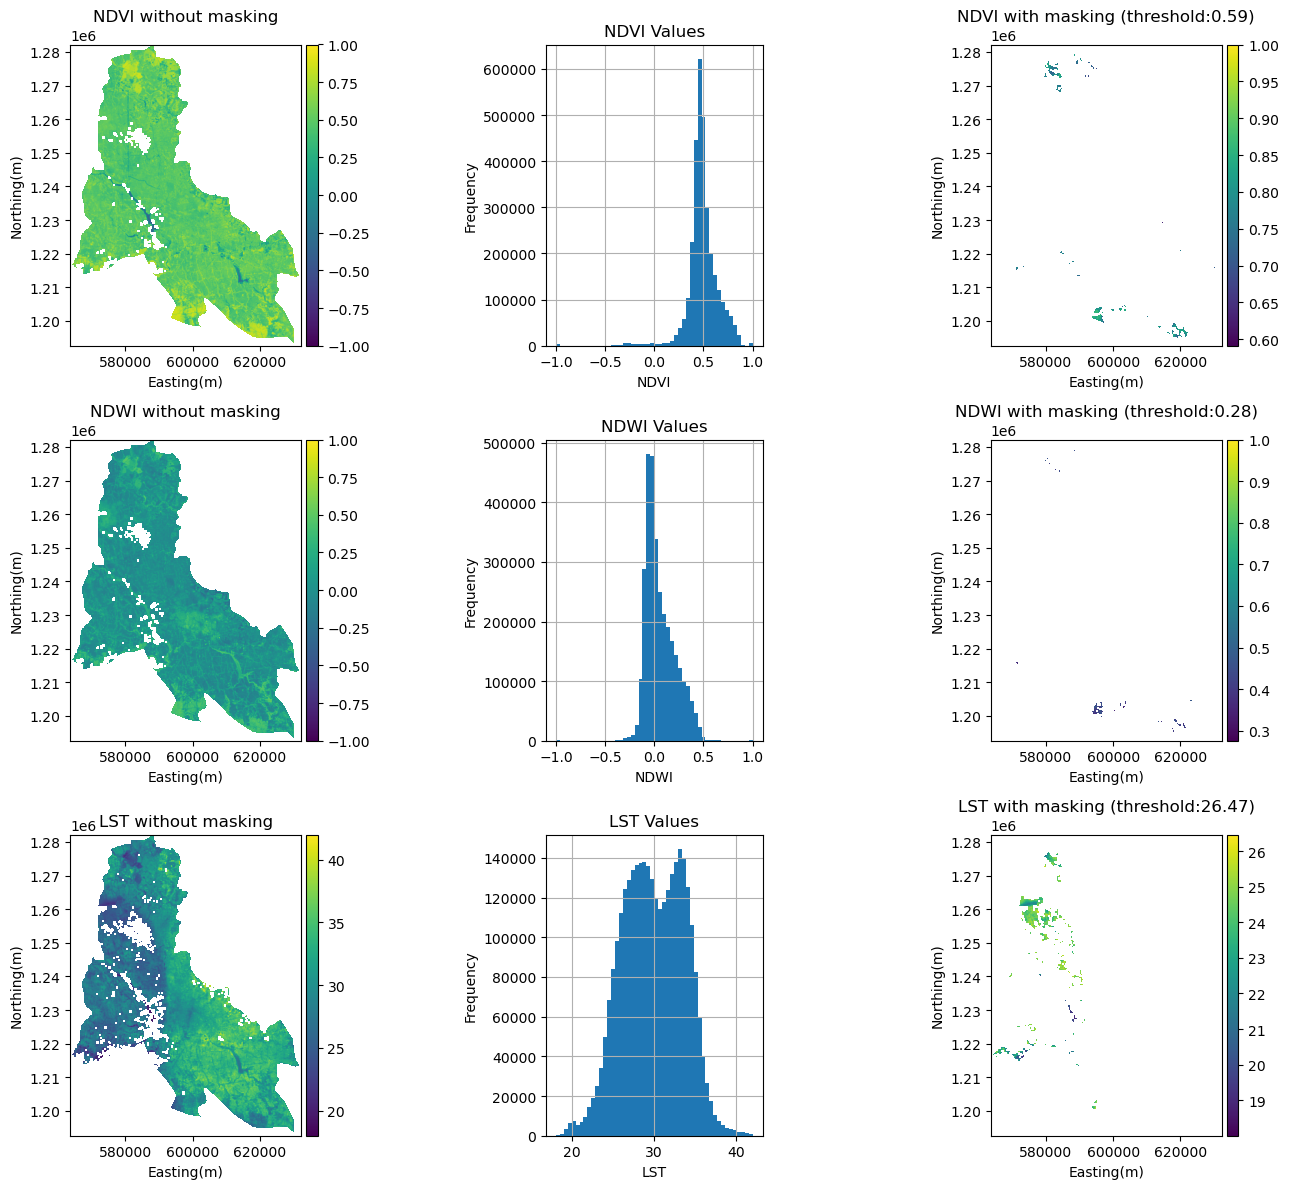

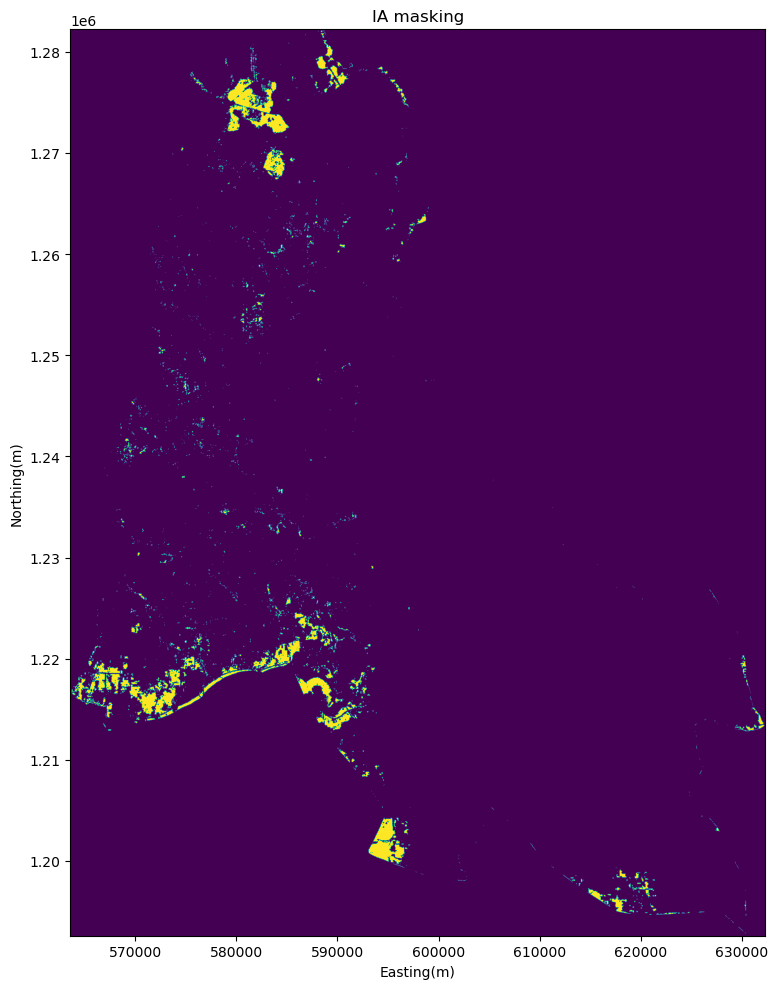

In [29]:
image_num = 12

print('Image file name: {}'.format(file_paths_l8[image_num]))
print('NDVI threshold: {:.2f}'.format(ndvi_threshold_list[image_num]))
print('NDWI threshold: {:.2f}'.format(ndwi_threshold_list[image_num]))
print('LST threshold: {:.2f}'.format(lst_threshold_list[image_num]))

print_mask(mask_list[image_num], ndvi_list[image_num], ndwi_list[image_num], lst_list[image_num], ras_list[image_num], ndvi_threshold_list[image_num], ndwi_threshold_list[image_num], lst_threshold_list[image_num])

## Layer stacking for IA

In [30]:
stack_mask_list = np.stack(mask_list, axis = 0)
combined_mask_l8 = np.full((stack_mask_list.shape[1], 
                                stack_mask_list.shape[2]), 
                                np.nan)

In [31]:
# iterate over row
for row in np.arange(stack_mask_list.shape[1]):
    # iterate over column
    for col in np.arange(stack_mask_list.shape[2]):
        timeseries_mask_value = stack_mask_list[:, row, col]
        
        if timeseries_mask_value.sum() != 0:
            percentage = timeseries_mask_value.sum()/stack_mask_list.shape[0]
            combined_mask_l8[row, col] = np.round(percentage, 2)

In [32]:
print('Min:', np.nanmin(combined_mask_l8))
print('Max:',np.nanmax(combined_mask_l8))


Min: 0.03
Max: 0.7


Text(0, 0.5, 'Northing(m)')

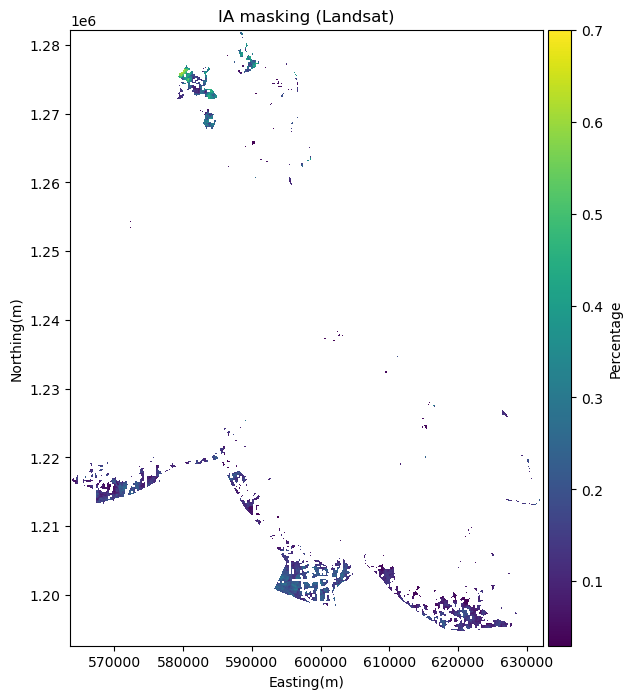

In [33]:
fig,ax = plt.subplots(figsize=(8,8))
# Visualize the mask
im = rasterio.plot.show(combined_mask_l8, ax=ax, transform=ras.transform)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical', label='Percentage')

ax.set_title('IA masking (Landsat)')
ax.set_xlabel('Easting(m)')
ax.set_ylabel('Northing(m)')

Text(0, 0.5, 'Northing(m)')

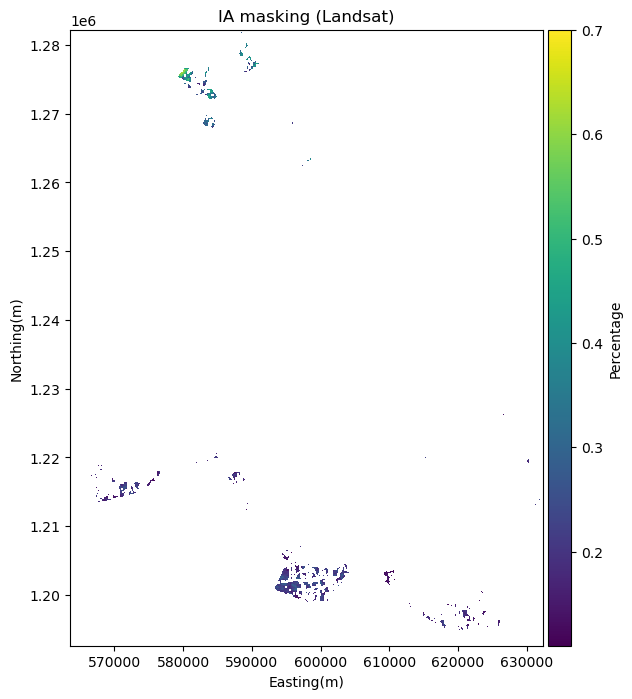

In [34]:
final_mask_l8 = np.where(combined_mask_l8>=0.1, combined_mask_l8, np.nan)

fig,ax = plt.subplots(figsize=(8,8))

# Visualize the mask
im = rasterio.plot.show(final_mask_l8, ax=ax, transform=ras.transform)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical', label='Percentage')

ax.set_title('IA masking (Landsat)')
ax.set_xlabel('Easting(m)')
ax.set_ylabel('Northing(m)')

## Plot the masking 

## Export to gif

In [35]:
# for i in range(len(mask_list)):
#     mask = mask_list[i]
#     fig,ax = plt.subplots(figsize=(8,8))
#     # Visualize the mask
#     im = rasterio.plot.show(mask, ax=ax, transform=ras.transform)
    
#     im = im.get_images()[0]
#     ax.set_title(f'IA masking {file_paths_l8[i][33:43]}')
#     ax.set_xlabel('Easting(m)')
#     ax.set_ylabel('Northing(m)')
    
#     plt.savefig(os.path.join('Landsat8_mask', f'{file_paths_l8[i][33:43]}.png'), dpi = 100)

In [36]:
# import os
# import imageio

# def make_gif(input_folder, save_filepath):
#     time_per_step = 0.8
#     with imageio.get_writer(save_filepath, mode='I', duration=time_per_step) as writer:
#         for root, _, files in os.walk(input_folder):
#             file_paths = [os.path.join(root, file) for file in files if file.endswith('.png')]
#             file_paths = sorted(file_paths, key=lambda x: os.path.getmtime(x))
#             for file_path in file_paths:
#                 image = imageio.imread(file_path)
#                 writer.append_data(image)

# # Example usage:
# outdir = 'Landsat8_mask'

# make_gif(outdir, os.path.join(outdir, 'Animation.gif'))

In [37]:
# image_num = 14

# print('Image file name: {}'.format(file_paths_l8[image_num]))
# print('NDVI threshold: {:.2f}'.format(ndvi_threshold_list[image_num]))
# print('NDWI threshold: {:.2f}'.format(ndwi_threshold_list[image_num]))
# print('LST threshold: {:.2f}'.format(lst_threshold_list[image_num]))

# print_mask(mask_list[image_num], ndvi_list[image_num], ndwi_list[image_num], lst_list[image_num], ras_list[image_num], ndvi_threshold_list[image_num], ndwi_threshold_list[image_num], lst_threshold_list[image_num])

## NDVI time series

In [38]:
final_mask_l8 = np.where(combined_mask_l8>=0.1, True, False)
# Example usage:
top_directory_l8 = 'Data/Landsat8_projected'
file_paths_l8 = get_file_paths(top_directory_l8)

# Create a list to store mask, ndvi, ndwi, lst, and thresholds
mask_list = []
ndvi_list = []
ndwi_list = []
lst_list = []
ndvi_threshold_list = []
ndwi_threshold_list = []
lst_threshold_list = []
ras_list = []

# NDVI timeseries
ndvi_timeseries = {}


# Loop through 'file_paths' and process each file as needed
for l8_file in file_paths_l8:
    # Read files
    all_bands, ras = landsat_read(l8_file)
    
    # Get image date 
    date = l8_file[33:43]
    
    # Calculate NDVI for the current image
    red_band = all_bands[3]
    nir_band = all_bands[4]
    ndvi = cal_ndvi(red_band, nir_band)
    
    # Calculate NDWI 
    swir_band = all_bands[5]
    ndwi = cal_ndwi(nir_band, swir_band)
    
    # LST data
    lst = all_bands[7]
    
    
    # Store everything in list
    ndvi_list.append(ndvi)
    ndwi_list.append(ndwi)
    lst_list.append(lst)
    ndvi_threshold_list.append(ndvi_threshold)
    ndwi_threshold_list.append(ndwi_threshold)
    lst_threshold_list.append(lst_threshold)
    ras_list.append(ras)
    
    ndvi_timeseries[date] = np.nanmean(ndvi[final_mask_l8])

In [39]:
ndvi_series_l8 = ndvi_timeseries.copy()
ndvi_l8_df = pd.DataFrame.from_dict(ndvi_series_l8, orient='index', columns= ['Average NDVI'])
ndvi_l8_df.index = pd.to_datetime(ndvi_l8_df.index)
ndvi_l8_df = ndvi_l8_df.reset_index()
display(ndvi_l8_df.head())
ndvi_l8_df.loc[ndvi_l8_df['Average NDVI'] == ndvi_l8_df['Average NDVI'].max()]

,index,Average NDVI
0,2016-01-11,0.670831
1,2016-02-28,0.574441
2,2016-03-15,0.487145
3,2016-03-31,0.463871
4,2016-04-16,0.408370


,index,Average NDVI
36,2018-12-18,0.737976


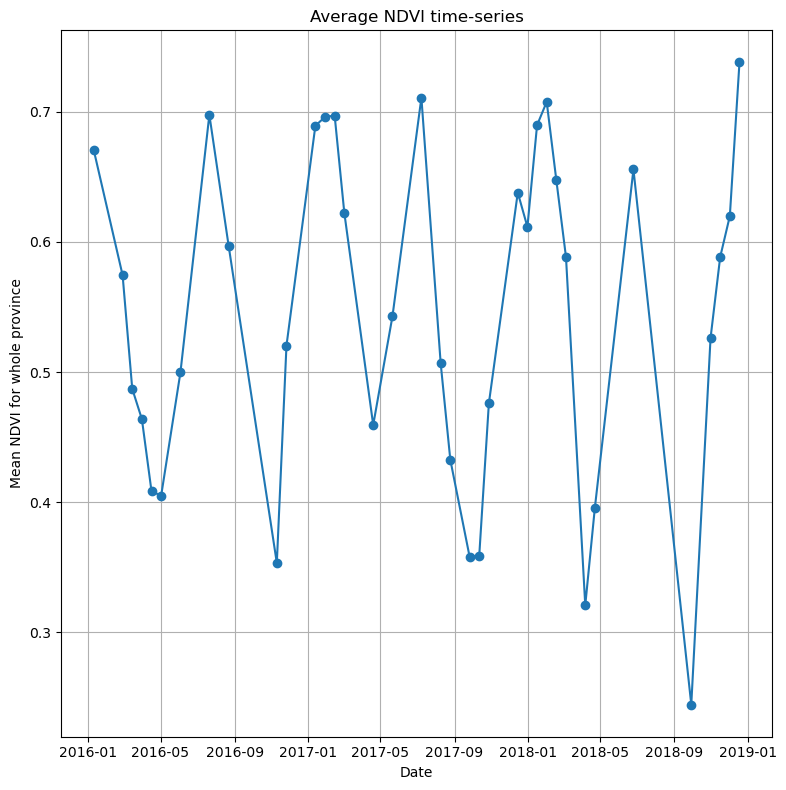

In [40]:
fig, ax = plt.subplots(figsize= (8,8))

ax.plot(ndvi_l8_df['index'], ndvi_l8_df['Average NDVI'], marker='o')

ax.set_title('Average NDVI time-series')
ax.set_xlabel('Date')
ax.set_ylabel('Mean NDVI for whole province')
plt.tight_layout()
plt.grid()
plt.show()

## With Filter


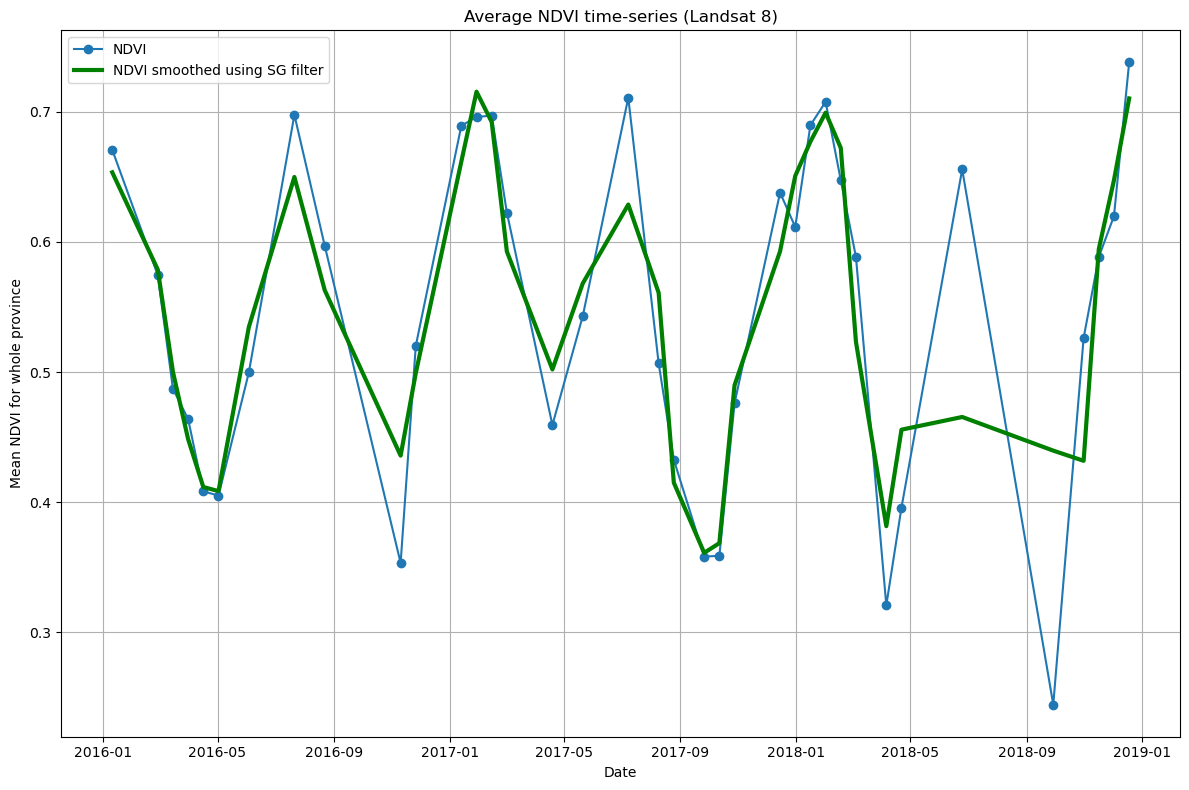

In [41]:
# Plot the smoothened data using SG filter
window = 5

fig, ax = plt.subplots(figsize= (12,8))

ax.plot(ndvi_l8_df['index'], ndvi_l8_df['Average NDVI'], marker='o', label='NDVI')

# Plot the SG filtered curve
y_smooth_l8 = signal.savgol_filter(ndvi_l8_df['Average NDVI'], window_length=window, polyorder=3, mode="nearest")
ax.plot(ndvi_l8_df['index'],y_smooth_l8, linewidth=3, c= 'green', label='NDVI smoothed using SG filter')

ax.set_title('Average NDVI time-series (Landsat 8)')
ax.set_xlabel('Date')
ax.set_ylabel('Mean NDVI for whole province')
ax.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Plots + masking

In [42]:
# test_file = file_paths_l8[22]
# test_file

In [43]:
# Reading the image with the highest average NVDI value
# all_bands, ras = landsat_read(test_file)

In [44]:
# Visualize Landsat 8 image data
# plotting normal TCC (blue as blue, green as green, red as red)
# fig, ax = plt.subplots(figsize = (8, 8))
# im = rasterio.plot.show(all_bands[[3,2,1], :, :], ax = ax, transform = ras.transform)
# ax.set_title('RGB (After reprojection on proper CRS)')
# ax.set_xlabel('Easting(m)')
# ax.set_ylabel('Northing(m)')
# plt.show()

In [45]:
# red_band = all_bands[3]
# nir_band = all_bands[4]
# ndvi = cal_ndvi(red_band, nir_band)

# # Calculate NDWI 
# swir_band = all_bands[5]
# ndwi = cal_ndwi(nir_band, swir_band)

In [46]:
# ndvi_ndwi_lst_plots(ndvi, ndwi, all_bands[7], ras, ndvi_threshold = 0.4, ndwi_threshold = 0.2, lst_threshold = 35)

# MODIS Images

In [47]:
# Example usage:
top_directory = 'Data/MODIS_sur_reprojected'
file_paths_modis = get_file_paths(top_directory)

# Now 'file_paths' contains the paths to all files in the directory and its subdirectories
# You can loop through 'file_paths' and process each file as needed
# for file_path in file_paths_modis:
#     print("File Path:", file_path)

In [48]:
# Example usage:
top_directory_modis_lst = 'Data/MODIS_lst_reprojected'
file_paths_modis_lst = get_file_paths(top_directory_modis_lst)

## NDVI time-series test

In [49]:
# Create a list to store mask, ndvi, ndwi, lst, and thresholds
mask_list = []
ndvi_list = []
ndwi_list = []
lst_list = []
ndvi_threshold_list = []
ndwi_threshold_list = []
lst_threshold_list = []
ras_list = []


ndvi_timeseries_modis = {}
# Now 'file_paths' contains the paths to all files in the directory and its subdirectories
# You can loop through 'file_paths' and process each file as needed
for i in range(len(file_paths_modis)):
    # Read files
    modis_file = file_paths_modis[i]
    lst_file = file_paths_modis_lst[i]
    
    all_bands, ras = modis_read(modis_file)
    lst_band, ras_lst = modis_lst_read(lst_file)
    
    # Get image date 
    date = modis_file[33:43]
    

    # Calculate NDVI for the current image
    red_band = all_bands[0]
    nir_band = all_bands[1]
    ndvi = cal_ndvi(red_band, nir_band)
    
    # Calculate NDWI 
    swir_band = all_bands[5]
    ndwi = cal_ndwi(nir_band, swir_band)

    # LST 
    lst = lst_band[0]
    
    ia_mask, ndvi_threshold, ndwi_threshold, lst_threshold= ia_identification_modis(ndvi, ndwi, lst)

    
    # Calculate the NDVI timeseries
    if sum(ia_mask.flatten()) == 0:
        print(f'Error in file: {modis_file}')
        continue
    else:
        # Store in lists
        mask_list.append(ia_mask)
        ndvi_list.append(ndvi)
        ndwi_list.append(ndwi)
        lst_list.append(lst)
        ndvi_threshold_list.append(ndvi_threshold)
        ndwi_threshold_list.append(ndwi_threshold)
        lst_threshold_list.append(lst_threshold)
        ras_list.append(ras)
        
        
        ndvi_timeseries_modis[date] = np.nanmean(ndvi[ia_mask]) 

In [50]:
stack_mask_list=np.stack(mask_list, axis = 0)
combined_mask_modis = np.full((stack_mask_list.shape[1], 
                                stack_mask_list.shape[2]), 
                                np.nan)

In [51]:
# iterate over row
for row in np.arange(stack_mask_list.shape[1]):
    # iterate over column
    for col in np.arange(stack_mask_list.shape[2]):
        timeseries_mask_value = stack_mask_list[:, row, col]
        
        if timeseries_mask_value.sum() != 0:
            percentage = timeseries_mask_value.sum()/stack_mask_list.shape[0]
            combined_mask_modis[row, col] = np.round(percentage, 2)

In [52]:
print('Min:', np.nanmin(combined_mask_modis))
print('Max:',np.nanmax(combined_mask_modis))


Min: 0.01
Max: 0.59


Text(0, 0.5, 'Northing(m)')

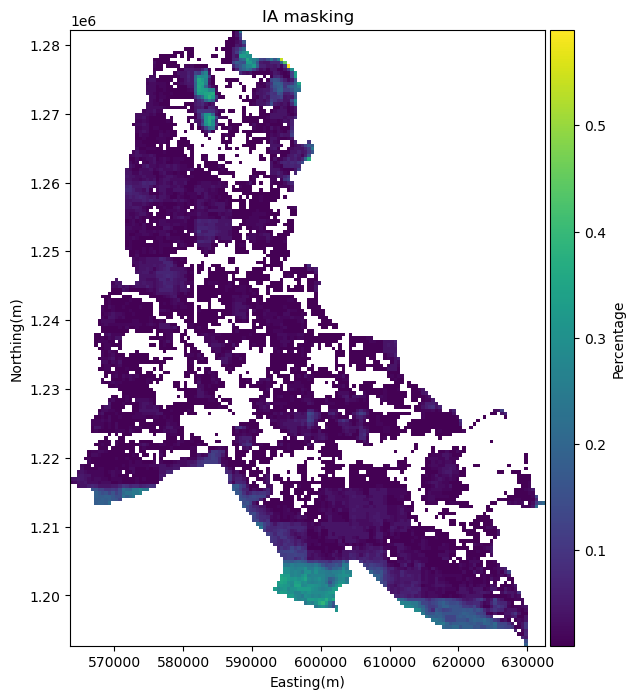

In [53]:
fig,ax = plt.subplots(figsize=(8,8))
# Visualize the mask
im = rasterio.plot.show(combined_mask_modis, ax=ax, transform=ras.transform)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical', label='Percentage')

ax.set_title(f'IA masking')
ax.set_xlabel('Easting(m)')
ax.set_ylabel('Northing(m)')

Text(0, 0.5, 'Northing(m)')

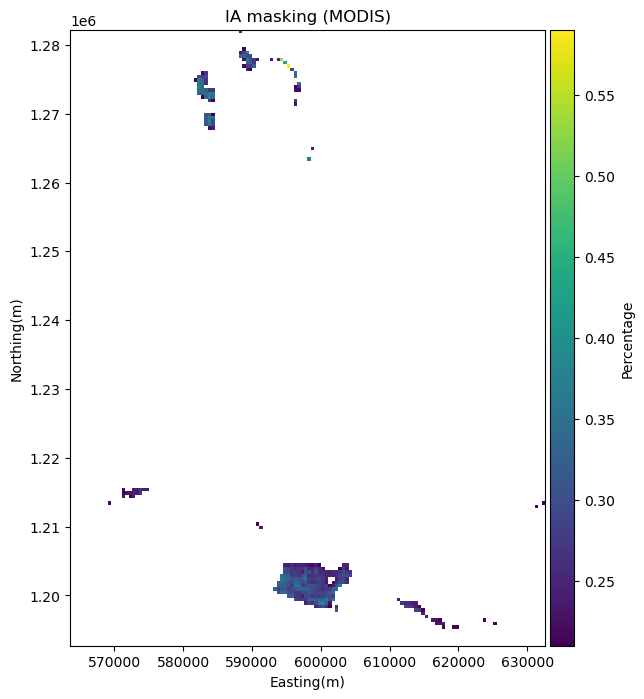

In [54]:
final_mask_modis = np.where(combined_mask_modis>0.2, combined_mask_modis, np.nan)

fig,ax = plt.subplots(figsize=(10,8))
# Visualize the mask
im = rasterio.plot.show(final_mask_modis, ax=ax, transform=ras.transform)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = im.get_images()[0]
fig.colorbar(im, cax=cax, orientation='vertical', label='Percentage')

ax.set_title('IA masking (MODIS)')
ax.set_xlabel('Easting(m)')
ax.set_ylabel('Northing(m)')

## Export to gif

In [55]:
# file_paths_modis[0][27:43]

In [56]:
# for i in range(len(mask_list)):
#     mask = mask_list[i]
#     fig,ax = plt.subplots(figsize=(8,8))
#     # Visualize the mask
#     im = rasterio.plot.show(mask, ax=ax, transform=ras.transform)
    
#     im = im.get_images()[0]
#     ax.set_title(f'IA masking {file_paths_modis[i][33:43]}')
#     ax.set_xlabel('Easting(m)')
#     ax.set_ylabel('Northing(m)')
    
#     plt.savefig(os.path.join('MODIS_mask', f'{file_paths_modis[i][27:43]}.png'), dpi = 100)

In [57]:
# import os
# import imageio

# def make_gif(input_folder, save_filepath):
#     time_per_step = 0.8
#     with imageio.get_writer(save_filepath, mode='I', duration=time_per_step) as writer:
#         for root, _, files in os.walk(input_folder):
#             file_paths = [os.path.join(root, file) for file in files if file.endswith('.png')]
#             file_paths = sorted(file_paths, key=lambda x: os.path.getmtime(x))
#             for file_path in file_paths:
#                 image = imageio.imread(file_path)
#                 writer.append_data(image)

# # Example usage:
# outdir = 'MODIS_mask'

# make_gif(outdir, os.path.join(outdir, 'Animation.gif'))

## Mask plots

Image file name: Data/MODIS_sur_reprojected\MODIS-2016-06-17.tif
NDVI threshold: 0.44
NDWI threshold: 0.10
LST threshold: 34.13


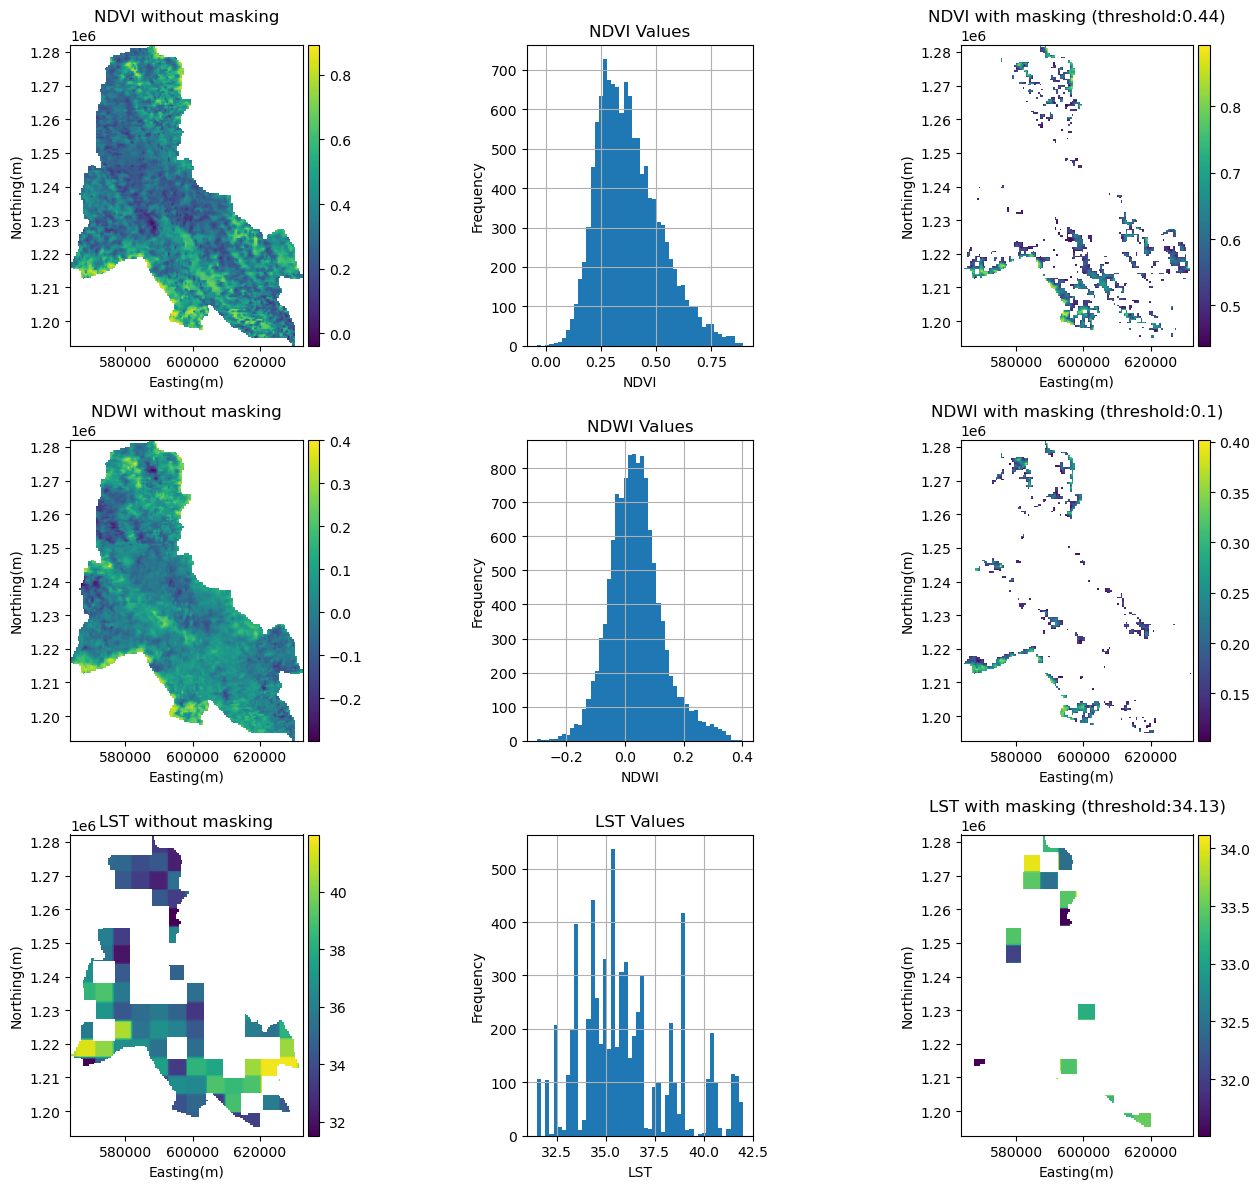

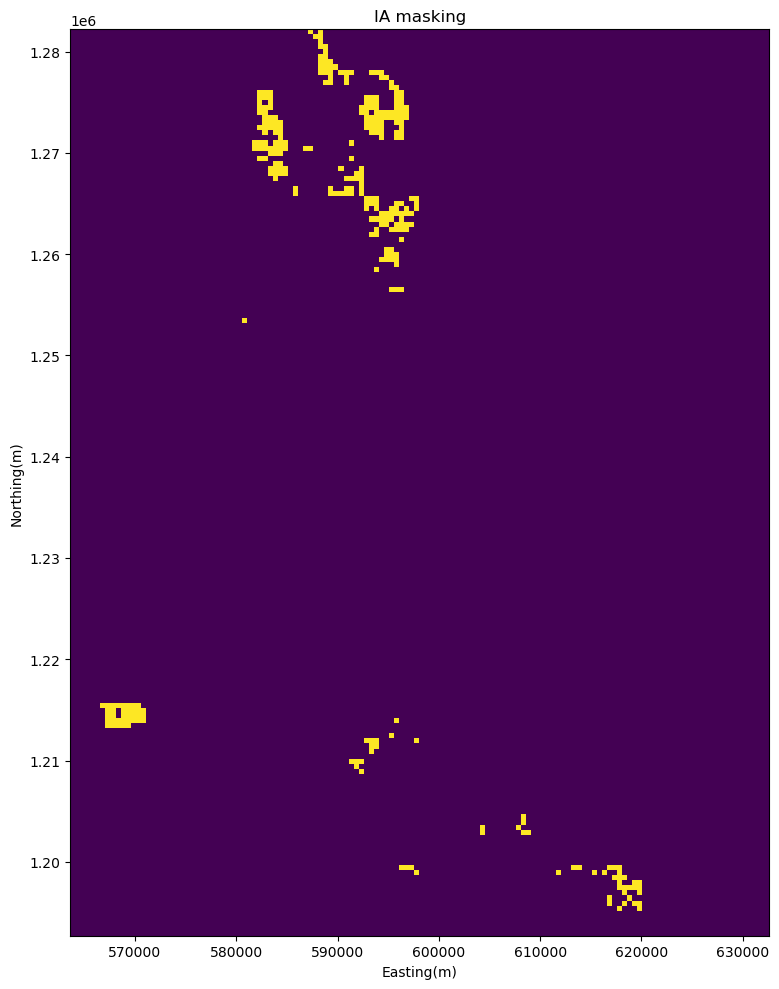

In [58]:
image_num = 20

print('Image file name: {}'.format(file_paths_modis[image_num]))
print('NDVI threshold: {:.2f}'.format(ndvi_threshold_list[image_num]))
print('NDWI threshold: {:.2f}'.format(ndwi_threshold_list[image_num]))
print('LST threshold: {:.2f}'.format(lst_threshold_list[image_num]))

print_mask(mask_list[image_num], ndvi_list[image_num], ndwi_list[image_num], lst_list[image_num], ras_list[image_num], ndvi_threshold_list[image_num], ndwi_threshold_list[image_num], lst_threshold_list[image_num])

## NDVI time series

In [59]:
final_mask_modis = np.where(combined_mask_modis>0.2, True, False)
final_mask_modis.sum()

334

In [60]:
# Create a list to store mask, ndvi, ndwi, lst, and thresholds
mask_list = []
ndvi_list = []
ndwi_list = []
lst_list = []
ndvi_threshold_list = []
ndwi_threshold_list = []
lst_threshold_list = []
ras_list = []


ndvi_timeseries_modis = {}
# Now 'file_paths' contains the paths to all files in the directory and its subdirectories
# You can loop through 'file_paths' and process each file as needed
for i in range(len(file_paths_modis)):
    # Read files
    modis_file = file_paths_modis[i]
    lst_file = file_paths_modis_lst[i]
    
    all_bands, ras = modis_read(modis_file)
    lst_band, ras_lst = modis_lst_read(lst_file)
    
    # Get image date 
    date = modis_file[33:43]
    

    # Calculate NDVI for the current image
    red_band = all_bands[0]
    nir_band = all_bands[1]
    ndvi = cal_ndvi(red_band, nir_band)
    
    # Calculate NDWI 
    swir_band = all_bands[5]
    ndwi = cal_ndwi(nir_band, swir_band)

    # LST 
    lst = lst_band[0]

    

    # Store in lists
    ndvi_list.append(ndvi)
    ndwi_list.append(ndwi)
    lst_list.append(lst)
    ndvi_threshold_list.append(ndvi_threshold)
    ndwi_threshold_list.append(ndwi_threshold)
    lst_threshold_list.append(lst_threshold)
    ras_list.append(ras)
    
    
    ndvi_timeseries_modis[date] = np.nanmean(ndvi[final_mask_modis]) 

In [61]:
ndvi_series_copy = ndvi_timeseries_modis.copy()
ndvi_df_modis = pd.DataFrame.from_dict(ndvi_series_copy, orient='index', columns= ['Average NDVI'])
ndvi_df_modis.index = pd.to_datetime(ndvi_df_modis.index)
ndvi_df_modis = ndvi_df_modis.reset_index()
display(ndvi_df_modis)
print(ndvi_df_modis.loc[ndvi_df_modis['Average NDVI'] == ndvi_df_modis['Average NDVI'].max()])

,index,Average NDVI
0,2016-01-01,0.699540
1,2016-01-09,0.645786
2,2016-01-17,0.629812
3,2016-01-25,0.604231
4,2016-02-02,0.600949
...,...,...
130,2018-11-25,0.573258
131,2018-12-03,0.795476
132,2018-12-11,0.803894
133,2018-12-19,0.782478


         index  Average NDVI
132 2018-12-11      0.803894


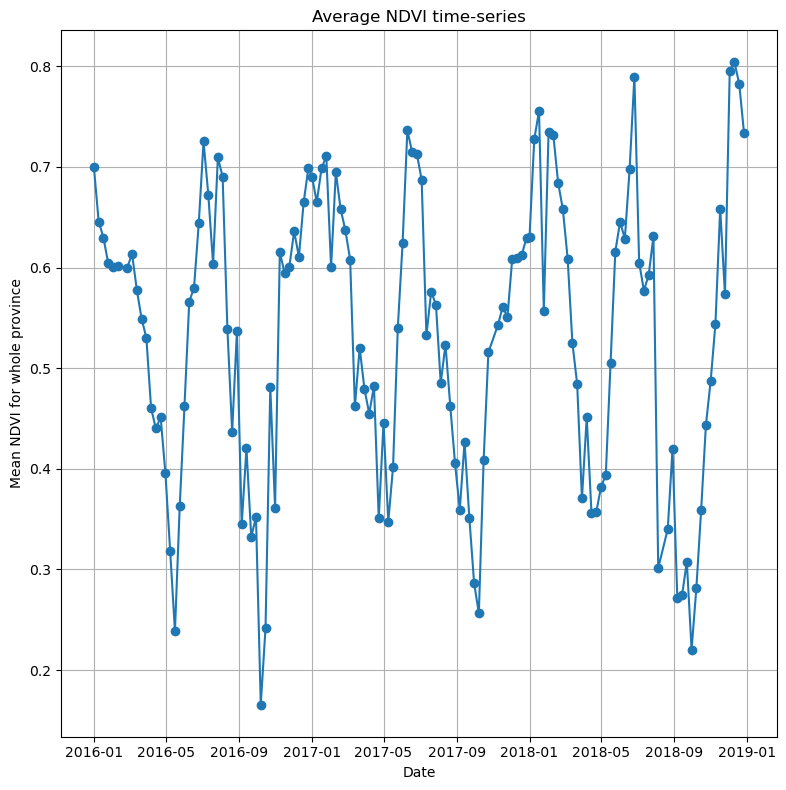

In [62]:
fig, ax = plt.subplots(figsize= (8,8))

ax.plot(ndvi_df_modis['index'], ndvi_df_modis['Average NDVI'], marker='o')

ax.set_title('Average NDVI time-series')
ax.set_xlabel('Date')
ax.set_ylabel('Mean NDVI for whole province')
plt.tight_layout()
plt.grid()
plt.show()

## With Filter


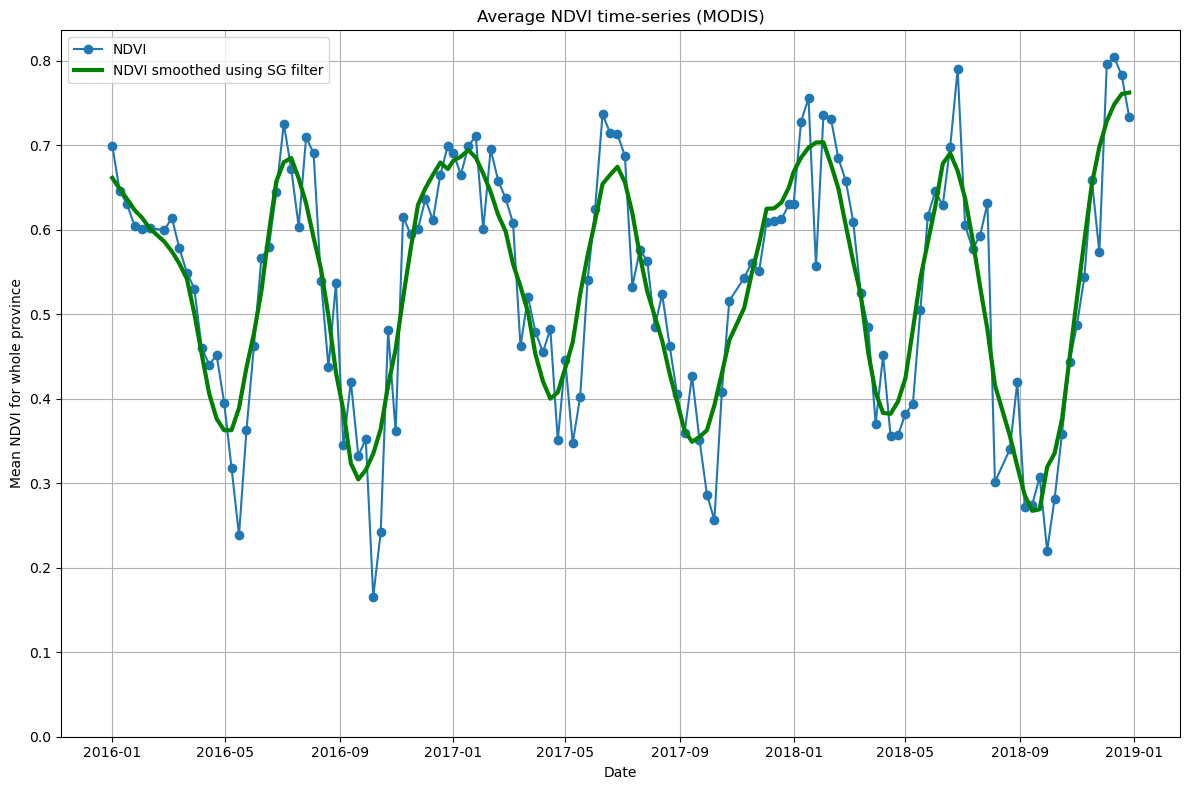

In [63]:
# Plot the smoothened data using SG filter
window = 14

fig, ax = plt.subplots(figsize= (12,8))

ax.plot(ndvi_df_modis['index'], ndvi_df_modis['Average NDVI'], marker='o', label='NDVI')

# Plot the SG filtered curve
y_smooth_modis = signal.savgol_filter(ndvi_df_modis['Average NDVI'], window_length=window, polyorder=3, mode="nearest")
ax.plot(ndvi_df_modis['index'],y_smooth_modis, linewidth=3, c= 'green', label='NDVI smoothed using SG filter')

ax.set_ylim(0)
ax.set_title('Average NDVI time-series (MODIS)')
ax.set_xlabel('Date')
ax.set_ylabel('Mean NDVI for whole province')
ax.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Export modis image to comfirm the scaling applied is correct

In [64]:
# Reading the image with the highest average NVDI value
# all_bands, modis_ras = modis_read(file_paths_modis[37])

In [65]:
# file_paths_modis[37][27::]

In [66]:
# output_path = '.Data'

# # create folder if it does not exist
# if not os.path.exists(output_path):
#     os.mkdir(output_path)
    
# # defining output path and filename
# out_raster_file = os.path.join(output_path, file_paths_modis[37][27::])

# out_profile = modis_ras.profile.copy()

# # exporting the raster 
# with rasterio.open(out_raster_file, 'w', **out_profile) as ds_out:
#     for i in range(1, modis_ras.count + 1):
#         rasterio.warp.reproject(source = all_bands[i-1],
#                                 destination = rasterio.band(ds_out, i),
#                                 src_crs = modis_ras.crs,
#                                 dst_crs = ds_out.crs,
#                                 dst_resolution = modis_ras.res,
#                                 # use bilinear resampling, suitable for continuous (not ordinal or nominal) data
#                                 resampling = Resampling.bilinear,
#                                 src_transform=modis_ras.transform,  # Specify the source transformation
#                                 dst_transform=ds_out.transform )

# Comparing MODIS and Landsat 8 results

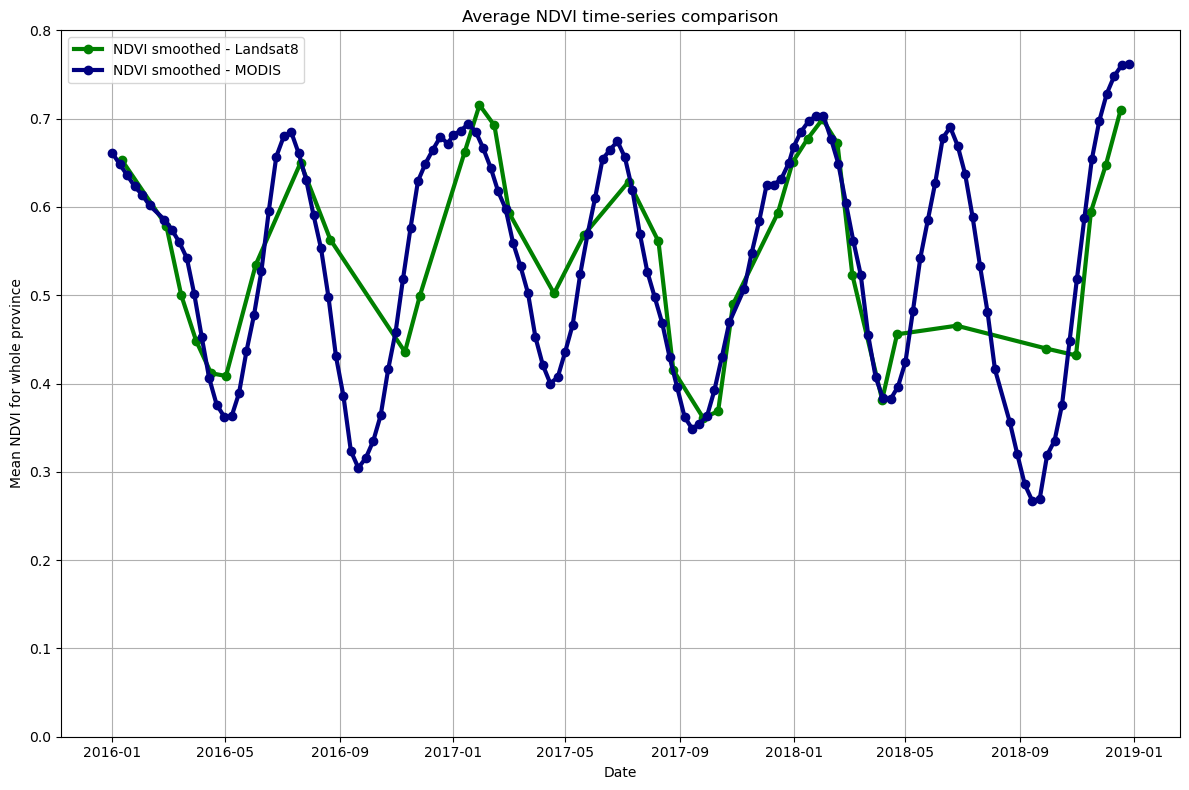

In [67]:
fig, ax = plt.subplots(figsize= (12,8))

ax.plot(ndvi_l8_df['index'], y_smooth_l8, linewidth=3, c= 'green', marker ='o', label='NDVI smoothed - Landsat8')
ax.plot(ndvi_df_modis['index'], y_smooth_modis, linewidth=3, c= 'navy', marker ='o', label='NDVI smoothed - MODIS')
ax.set_ylim(0,0.8)

ax.set_title('Average NDVI time-series comparison')
ax.set_xlabel('Date')
ax.set_ylabel('Mean NDVI for whole province')
ax.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Cropping Calendar

## Landsat 8

In [68]:
dx = len(y_smooth_l8)
first_derivative_l8 = np.gradient(y_smooth_l8, dx)
first_derivative_l8_smooth = signal.savgol_filter(first_derivative_l8, window_length=5, polyorder=3, mode="nearest")
second_derivative_l8 = np.gradient(first_derivative_l8, dx)
second_derivative_l8_smooth = signal.savgol_filter(second_derivative_l8, window_length=5, polyorder=3, mode="nearest")

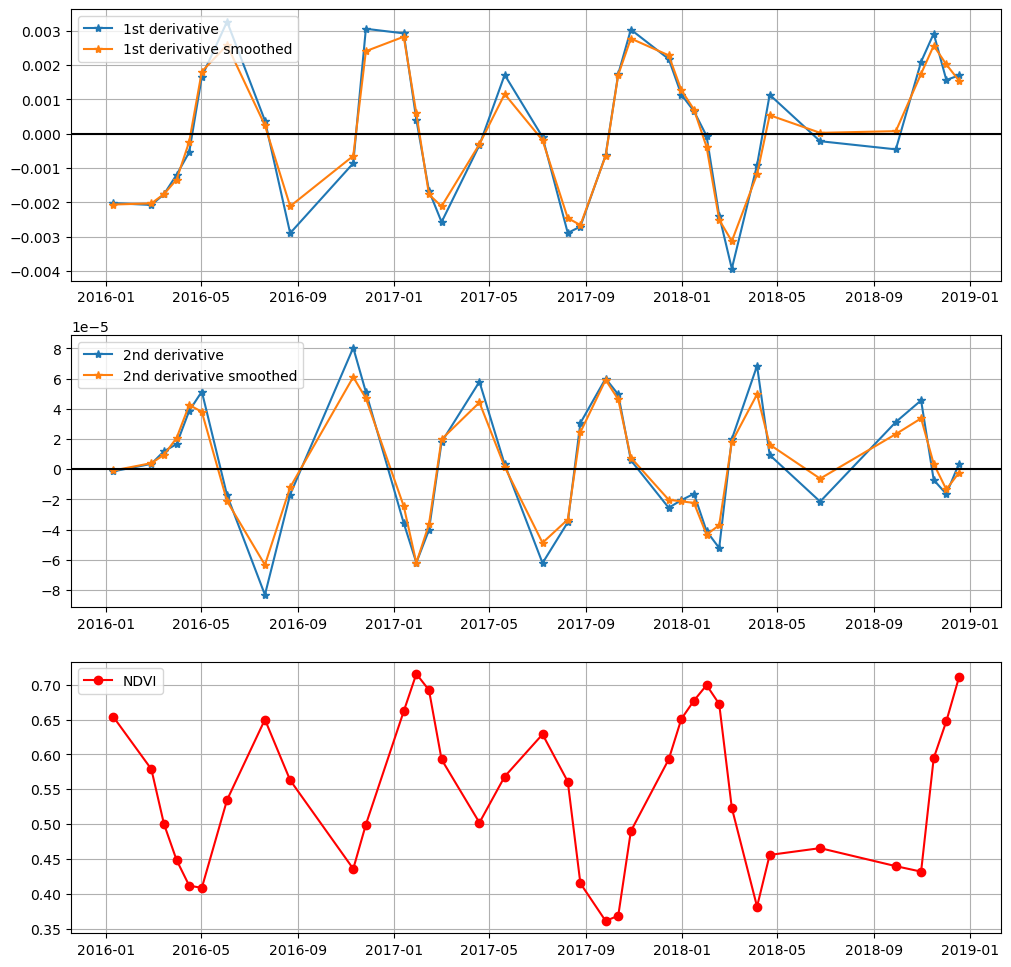

In [69]:
fig, ax = plt.subplots(3,1, figsize = (12,12))

# we calculate the derivative, with np.gradient
ax[0].plot(ndvi_l8_df['index'], first_derivative_l8, '-*', label='1st derivative')
ax[0].plot(ndvi_l8_df['index'], first_derivative_l8_smooth, '-*', label='1st derivative smoothed')
ax[0].axhline(0, c='k')

# we calculate the 2nd derivative, with np.gradient
ax[1].plot(ndvi_l8_df['index'], second_derivative_l8, '-*', label='2nd derivative')
ax[1].plot(ndvi_l8_df['index'], second_derivative_l8_smooth, '-*', label='2nd derivative smoothed')
ax[1].axhline(0, c='k')

# we compare it with the exact first derivative, i.e. cos(x)
ax[2].plot(ndvi_l8_df['index'], y_smooth_l8, '-o', label='NDVI', c='red')


ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')

ax[0].grid()
ax[1].grid()
ax[2].grid()

plt.show()

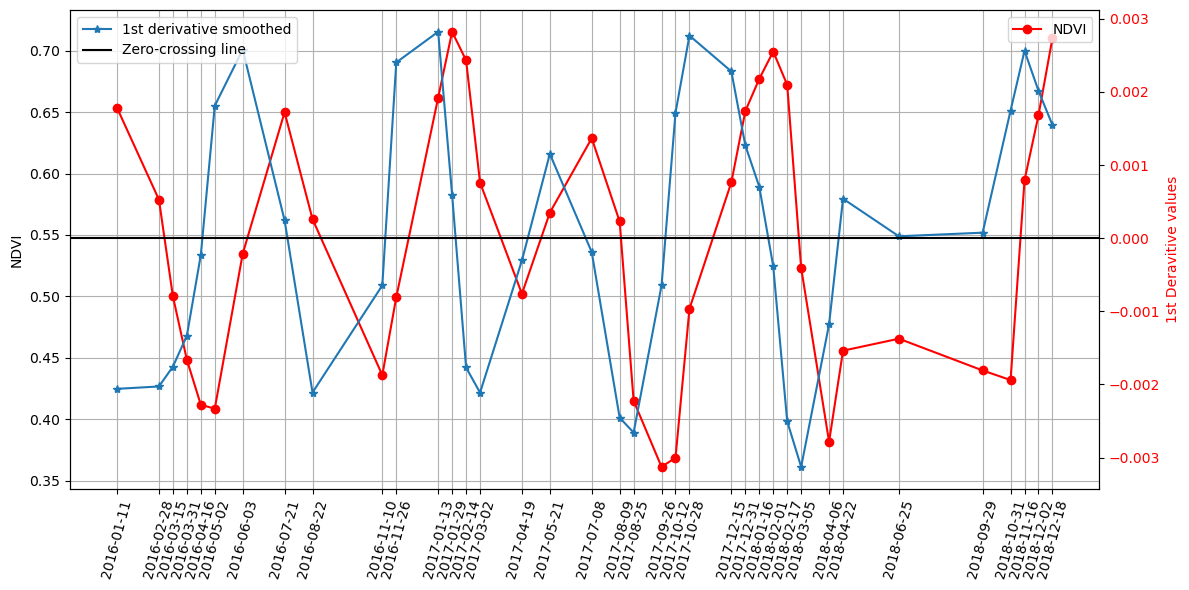

In [70]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(figsize = (12,6))

# 1st derivative
ax.plot(ndvi_l8_df['index'], y_smooth_l8, '-o', label='NDVI', c='red')
ax.set_ylabel('NDVI')
ax.set_xticks(ndvi_l8_df['index'])
ax.xaxis.set_major_formatter(myFmt)
ax1 = ax.twinx()
ax1.set_ylabel('1st Deravitive values', color='r')
ax1.plot(ndvi_l8_df['index'], first_derivative_l8_smooth, '-*', label='1st derivative smoothed')
ax1.tick_params(axis='y', labelcolor='r')
ax1.axhline(0, c='k', label= 'Zero-crossing line')
ax1.legend(loc='upper left')


# Manually adjust x-axis labels to right-align
xtick_positions = ax.get_xticks()
xtick_labels = ax.get_xticklabels()
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=75)

ax.legend(loc='upper right')

ax.grid()


plt.tight_layout()
plt.show()


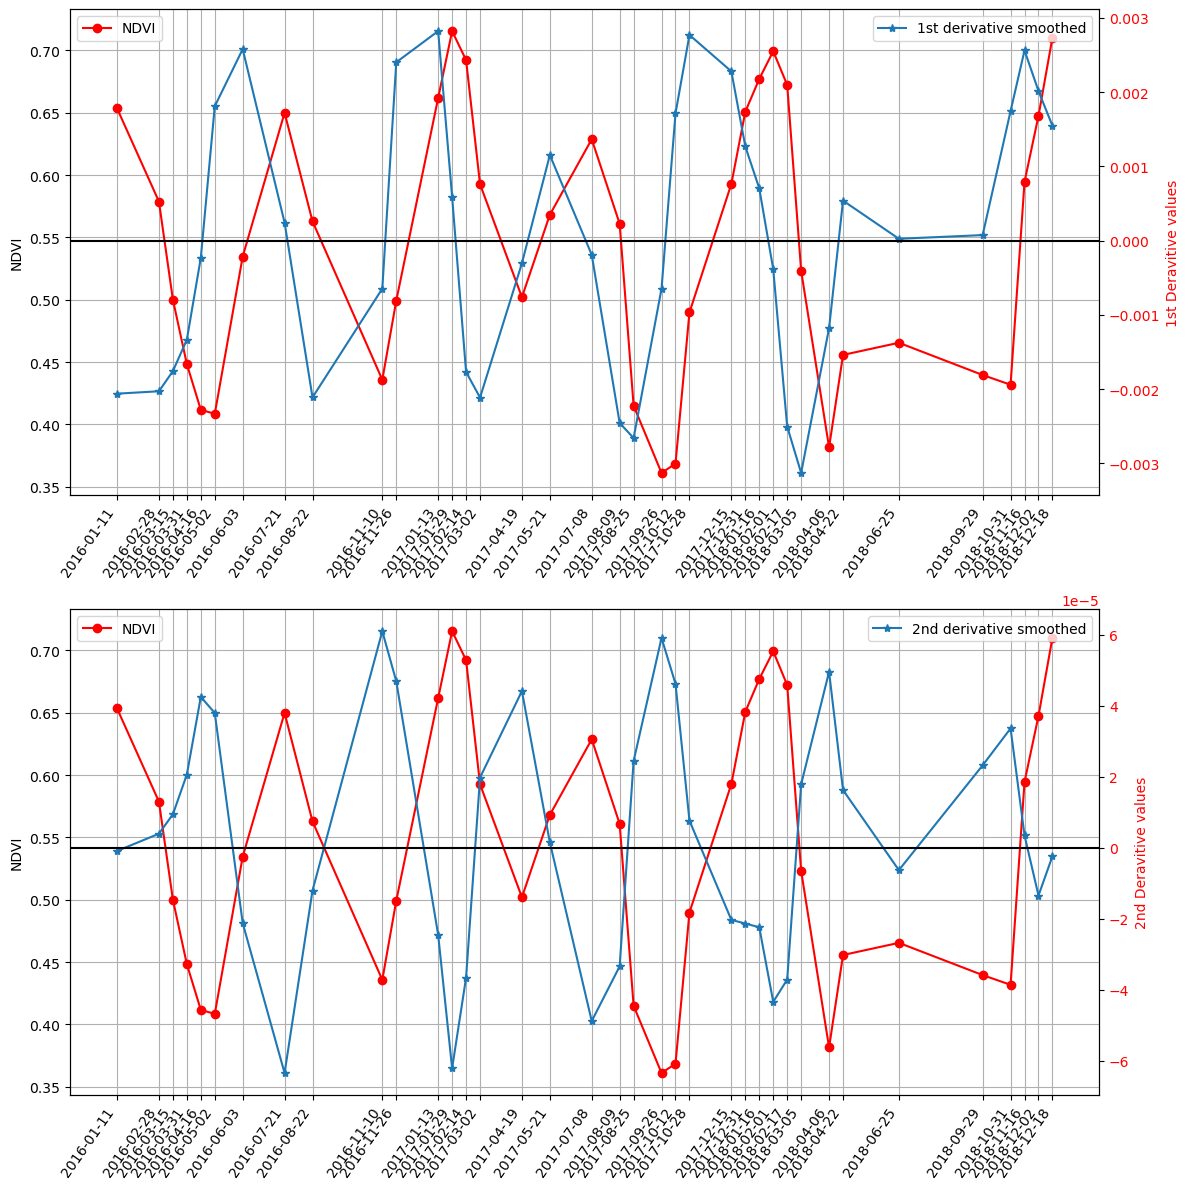

In [71]:
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(2,1, figsize = (12,12))

# 1st derivative
ax[0].plot(ndvi_l8_df['index'], y_smooth_l8, '-o', label='NDVI', c='red')
ax[0].set_ylabel('NDVI')
ax[0].set_xticks(ndvi_l8_df['index'])
ax[0].xaxis.set_major_formatter(myFmt)
ax1 = ax[0].twinx()
ax1.set_ylabel('1st Deravitive values', color='r')
ax1.plot(ndvi_l8_df['index'], first_derivative_l8_smooth, '-*', label='1st derivative smoothed')
ax1.tick_params(axis='y', labelcolor='r')
ax1.axhline(0, c='k')
ax1.legend(loc='upper right')
ax[0].tick_params(axis='x', rotation=55)

# Manually adjust x-axis labels to right-align
xtick_positions = ax[0].get_xticks()
xtick_labels = ax[0].get_xticklabels()
ax[0].set_xticks(xtick_positions)
ax[0].set_xticklabels(xtick_labels, rotation=55, ha='right')


# we calculate the 2nd derivative, with np.gradient
ax[1].plot(ndvi_l8_df['index'], y_smooth_l8, '-o', label='NDVI', c='red')
ax[1].set_xticks(ndvi_l8_df['index'])
ax[1].set_ylabel('NDVI')
ax[1].xaxis.set_major_formatter(myFmt)
ax2 = ax[1].twinx()
ax2.set_ylabel('2nd Deravitive values', color='r')
ax2.plot(ndvi_l8_df['index'], second_derivative_l8_smooth, '-*', label='2nd derivative smoothed')
ax2.tick_params(axis='y', labelcolor='r')
ax2.axhline(0, c='k')
ax2.legend(loc='upper right')


# Manually adjust x-axis labels to right-align
xtick_positions = ax[1].get_xticks()
xtick_labels = ax[1].get_xticklabels()
ax[1].set_xticks(xtick_positions)
ax[1].set_xticklabels(xtick_labels, rotation=55, ha='right')



ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

ax[0].grid()
ax[1].grid()

plt.tight_layout()
plt.show()

## MODIS

In [72]:
dx = len(y_smooth_modis)
first_derivative_modis = np.gradient(y_smooth_modis, dx)
first_derivative_modis_smooth = signal.savgol_filter(first_derivative_modis, window_length=12, polyorder=3, mode="nearest")
second_derivative_modis = np.gradient(first_derivative_modis, dx)
second_derivative_modis_smooth = signal.savgol_filter(second_derivative_modis, window_length=12, polyorder=3, mode="nearest")

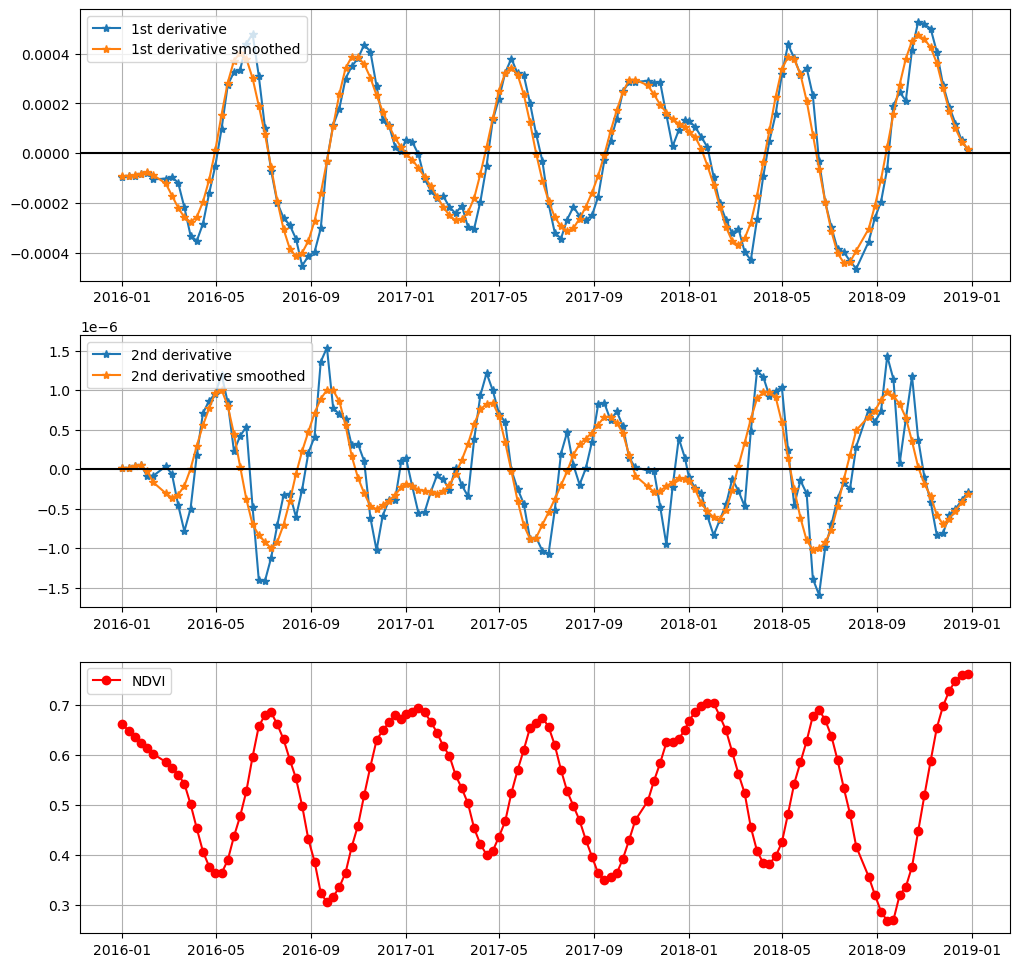

In [73]:
fig, ax = plt.subplots(3,1, figsize = (12,12))

# we calculate the derivative, with np.gradient
ax[0].plot(ndvi_df_modis['index'], first_derivative_modis, '-*', label='1st derivative')
ax[0].plot(ndvi_df_modis['index'], first_derivative_modis_smooth, '-*', label='1st derivative smoothed')
ax[0].axhline(0, c='k')

# we calculate the 2nd derivative, with np.gradient
ax[1].plot(ndvi_df_modis['index'], second_derivative_modis, '-*', label='2nd derivative')
ax[1].plot(ndvi_df_modis['index'], second_derivative_modis_smooth, '-*', label='2nd derivative smoothed')
ax[1].axhline(0, c='k')

# we compare it with the exact first derivative, i.e. cos(x)
ax[2].plot(ndvi_df_modis['index'], y_smooth_modis, '-o', label='NDVI', c='red')


ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')

ax[0].grid()
ax[1].grid()
ax[2].grid()

plt.show()

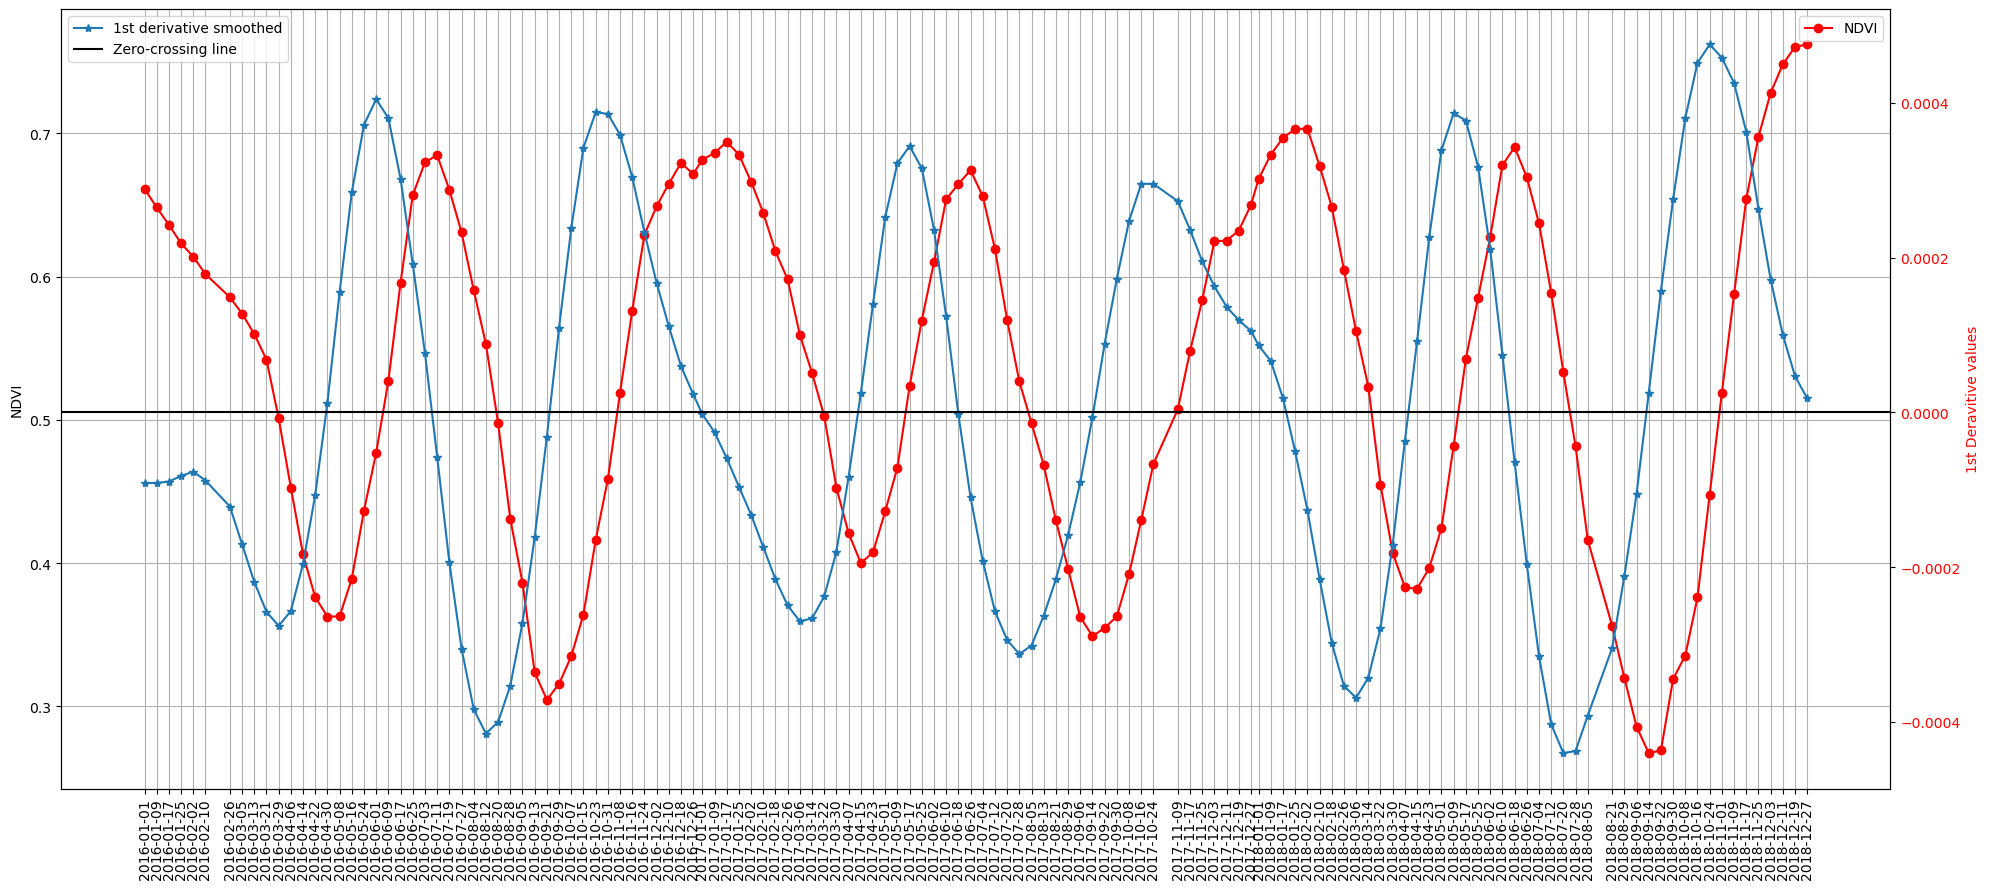

In [74]:
myFmt = mdates.DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(figsize = (20,9))

# 1st derivative
ax.plot(ndvi_df_modis['index'], y_smooth_modis, '-o', label='NDVI', c='red')
ax.set_ylabel('NDVI')
ax.set_xticks(ndvi_df_modis['index'])
ax.xaxis.set_major_formatter(myFmt)
ax1 = ax.twinx()
ax1.set_ylabel('1st Deravitive values', color='r')
ax1.plot(ndvi_df_modis['index'], first_derivative_modis_smooth, '-*', label='1st derivative smoothed')
ax1.tick_params(axis='y', labelcolor='r')
ax1.axhline(0, c='k', label= 'Zero-crossing line')
ax1.legend(loc='upper left')


# Manually adjust x-axis labels to right-align
xtick_positions = ax.get_xticks()
xtick_labels = ax.get_xticklabels()
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=90)
ax.legend(loc='upper right')

ax.grid()


plt.tight_layout()
plt.show()

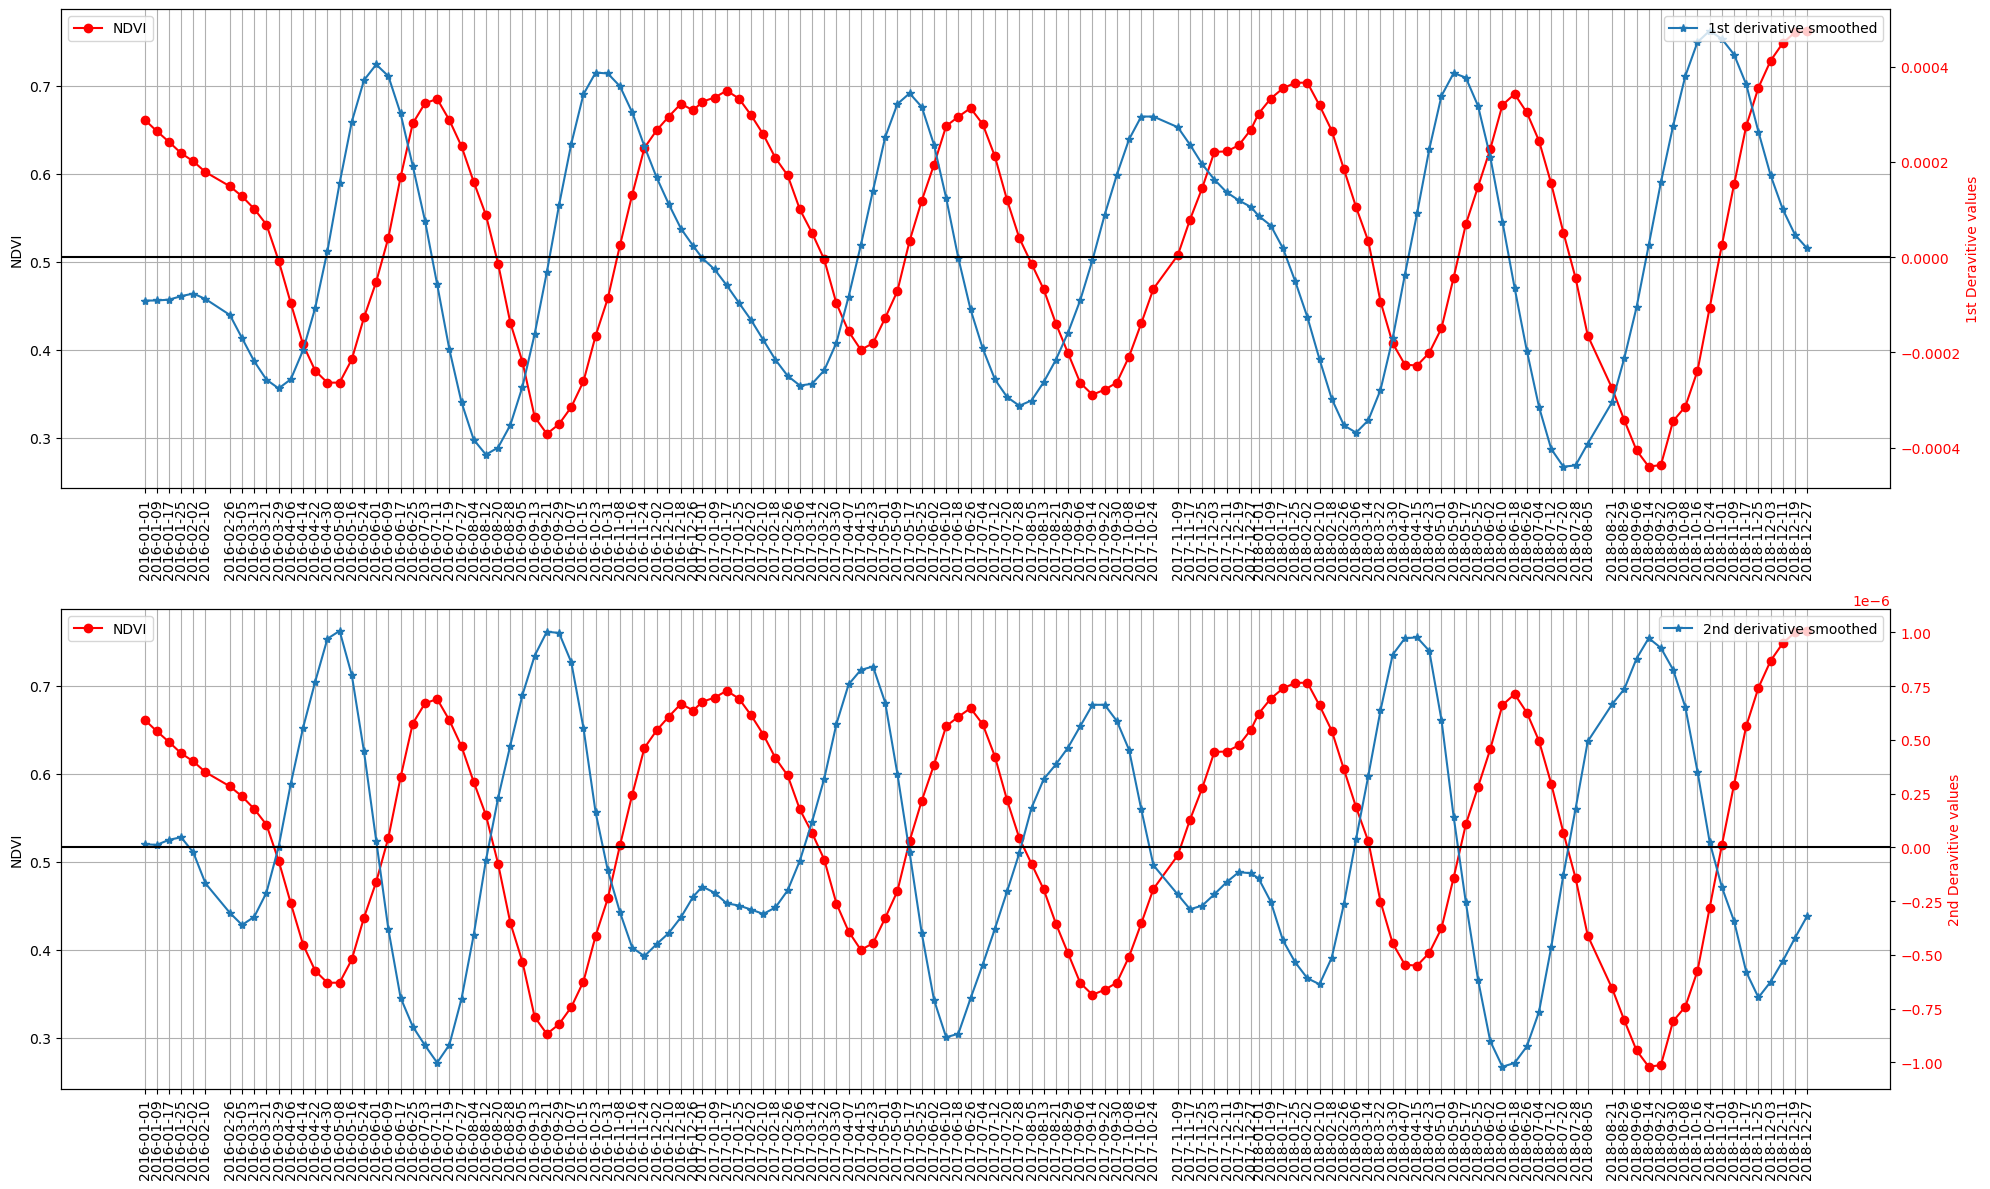

: 

In [75]:
myFmt = mdates.DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(2,1, figsize = (20,12))

# 1st derivative
ax[0].plot(ndvi_df_modis['index'], y_smooth_modis, '-o', label='NDVI', c='red')
ax[0].set_ylabel('NDVI')
ax[0].set_xticks(ndvi_df_modis['index'])
ax[0].xaxis.set_major_formatter(myFmt)
ax1 = ax[0].twinx()
ax1.set_ylabel('1st Deravitive values', color='r')
ax1.plot(ndvi_df_modis['index'], first_derivative_modis_smooth, '-*', label='1st derivative smoothed')
ax1.tick_params(axis='y', labelcolor='r')
ax1.axhline(0, c='k')
ax1.legend(loc='upper right')


# Manually adjust x-axis labels to right-align
xtick_positions = ax[0].get_xticks()
xtick_labels = ax[0].get_xticklabels()
ax[0].set_xticks(xtick_positions)
ax[0].set_xticklabels(xtick_labels, rotation=90)

# we calculate the 2nd derivative, with np.gradient
ax[1].plot(ndvi_df_modis['index'], y_smooth_modis, '-o', label='NDVI', c='red')
ax[1].set_xticks(ndvi_df_modis['index'])
ax[1].set_ylabel('NDVI')
ax[1].xaxis.set_major_formatter(myFmt)
ax2 = ax[1].twinx()
ax2.set_ylabel('2nd Deravitive values', color='r')
ax2.plot(ndvi_df_modis['index'], second_derivative_modis_smooth, '-*', label='2nd derivative smoothed')
ax2.tick_params(axis='y', labelcolor='r')
ax2.axhline(0, c='k')
ax2.legend(loc='upper right')


# Manually adjust x-axis labels to right-align
xtick_positions = ax[1].get_xticks()
xtick_labels = ax[1].get_xticklabels()
ax[1].set_xticks(xtick_positions)
ax[1].set_xticklabels(xtick_labels, rotation=90)


ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

ax[0].grid()
ax[1].grid()

plt.tight_layout()
plt.show()

## MODIS_LST

## Mention the scaling in the report/presentation
## Try to plot the correlation between MODIS and Landsat temperature data
## Threshold the NDVI, NDWI, and LST use quantile